# <center> Проект: Предсказание рейтинга отеля

 ## <center> Загрузка данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

from datetime import date

from scipy import stats

from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from geopy.geocoders import Nominatim
from geopy import distance

import category_encoders as ce # импорт для работы с кодировщиком

from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import SelectPercentile

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor 
# инструменты для оценки точности модели
from sklearn import metrics 

import warnings 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/kaggle/input/gdp-of-all-countries19602020/gdp_1960_2020.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
/kaggle/input/most-visited-countries-in-the-world/csvData (1).csv
/kaggle/input/languages-spoken-across-various-nations/countries-languages.csv
/kaggle/input/world-cities-population-cleaned-version/population-cleaned.csv


In [2]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
# Фиксируем версию пакетов
!pip freeze > requirements.txt

In [4]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## <center>  Исследование структуры данных

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = True # помечаем где у нас трейн
df_test['sample'] = False # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/tmp/ipykernel_32/2540878737.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [12]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

##  <center> Проектирование признаков

### Создание признаков hotel_country, hotel_city (страна и город отеля)

In [13]:
# Создаем новые номинальные признаки из адреса отеля: страна, город
def get_country_city(feature):
    found = re.findall(r'United \b[A-Za-z]+\b|\b[A-Za-z]+\b', feature)
    return found[-1], found[-2]

hotels[['hotel_country','hotel_city']] = hotels['hotel_address'].apply(get_country_city).to_list()
# Переводим признаки hotel_country и hotel_city в категориальный тип данных
hotels[['hotel_country','hotel_city']] = hotels[['hotel_country','hotel_city']].astype('category')

### Основные статистические характеристики целевого признака reviewer_score, в разрезе по странам\городам отелей

In [14]:
print('Целевой признак reviewer_score, в разрезе по странам\городам отелей:')
hotels[hotels['sample']].groupby(
    ['hotel_country','hotel_city']
    )['reviewer_score'].describe().round(2)

Целевой признак reviewer_score, в разрезе по странам\городам отелей:


,,count,mean,std,min,25%,50%,75%,max
hotel_country,hotel_city,,,,,,,,
Austria,Vienna,29178.0,8.55,1.51,2.5,7.9,9.2,9.6,10.0
France,Paris,44830.0,8.42,1.65,2.5,7.5,8.8,9.6,10.0
Italy,Milan,27883.0,8.36,1.64,2.5,7.5,8.8,9.6,10.0
Netherlands,Amsterdam,43006.0,8.45,1.60,2.5,7.5,8.8,9.6,10.0
Spain,Barcelona,45132.0,8.55,1.56,2.5,7.9,9.2,9.6,10.0
United Kingdom,London,196774.0,8.33,1.67,2.5,7.5,8.8,9.6,10.0


Визуально средняя оценка, в разрезе городов, различается не значительно. Признак страна отеля излишен, т.к. по количеству своих иникальных значений совпадает с признаком город отеля. 

In [15]:
# Добавляем признак hotel_country в список для удаления
features_for_del = ['hotel_country']

### Создание признака tourist_arrivals (туристические прибытия в страну отеля)

In [16]:
# Загружаем из внешнего датасета справочник самых посещаемых стран
Most_Visited_Countries = pd.read_csv(
    '/kaggle/input/most-visited-countries-in-the-world/csvData (1).csv')

In [17]:
# Оставляем в справочнике самых посещаемых стран, только 
# те страны, которые есть в признаке country
Most_Visited_Countries=Most_Visited_Countries[
    Most_Visited_Countries['country'].isin(hotels['hotel_country'])]
print('Справочник посещаемости стран туристами:')
Most_Visited_Countries

Справочник посещаемости стран туристами:


,country,touristArrivals
0,France,89400000
1,Spain,83700000
4,Italy,64500000
9,United Kingdom,39400000
11,Austria,31900000
19,Netherlands,20100000


In [18]:
# Создаем непрерывный признак tourist_arrivals - туристические прибытия в страну отеля
hotels['tourist_arrivals'] = hotels.merge(Most_Visited_Countries,
            left_on='hotel_country', right_on='country', how='left')['touristArrivals']
print('Непрерывный признак tourist_arrivals:')
hotels['tourist_arrivals'].describe()

Непрерывный признак tourist_arrivals:


count    5.157380e+05
mean     4.947997e+07
std      2.255641e+07
min      2.010000e+07
25%      3.940000e+07
50%      3.940000e+07
75%      6.450000e+07
max      8.940000e+07
Name: tourist_arrivals, dtype: float64

Корреляция между признаком tourist_arrivals и целевым признаком reviewer_score: 0.442%


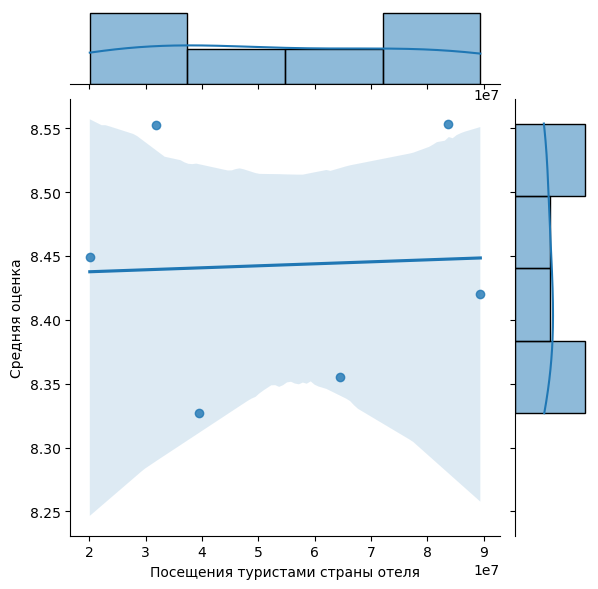

In [19]:
tourist_arrivals = hotels[hotels['sample']].groupby(
    ['tourist_arrivals'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=tourist_arrivals, 
    x='tourist_arrivals', y='reviewer_score',kind='reg')
plt.xlabel('Посещения туристами страны отеля');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком tourist_arrivals и целевым признаком reviewer_score: {}%'
      .format(round(hotels[['tourist_arrivals','reviewer_score']].
                    corr().iloc[0,1] * 100, 3)))

Визуально отображается корреляция близкая к нулю. Скорее всего признак будет удален.

### Создание признака hotel_country_gdp_rank (рейтинг ВВП страны отеля) и reviewer_country_gdp_rank (рейтинг ВВП страны рецензента)

In [20]:
# Загружаем из внешнего датасета справочник ВВП по странам
GDP = pd.read_csv('/kaggle/input/gdp-of-all-countries19602020/gdp_1960_2020.csv')

In [21]:
# Убирем пробелы в начале и в конце строки в признаке reviewer_nationality
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
# Переводим строковый признак review_date во временной тип данных, т.к. в этом сейчас 
# появилась необходимость
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# Оставляем в справочнике ВВП по странам только год равный максимальному году 
# размещения отзывов, и страны которые есть в признаке hotel_country
GDP=GDP[(GDP['year']==hotels['review_date'].dt.year.max())&
   (GDP['country'].isin(hotels['hotel_country'])|
     GDP['country'].isin(hotels['reviewer_nationality']))]
# Корректируем справичник
GDP = GDP.drop(9419, axis=0) # удаляем дубликат
GDP.loc[GDP[GDP['country']=='the United States'].index,'country']='United States of America'
GDP.loc[GDP[GDP['country']=='Czech'].index,'country']='Czech Republic'
print('Справочник рейтинга ВВП по странам:')
GDP

Справочник рейтинга ВВП по странам:


,year,rank,country,state,gdp,gdp_percent
9353,2017,2,China,Asia,12310409370894,1.536093e-01
9354,2017,3,Japan,Asia,4866864409657,6.072876e-02
9355,2017,4,Germany,Europe,3673506280844,4.583803e-02
9356,2017,5,United Kingdom,Europe,2662484018735,3.322249e-02
9357,2017,6,India,Asia,2651472946375,3.308509e-02
...,...,...,...,...,...,...
9546,2017,195,American Samoa,Oceania,612000000,7.636539e-06
9547,2017,196,Dominica,America,519837037,6.486529e-06
9551,2017,200,Palau,Oceania,286106800,3.570042e-06
9553,2017,202,Kiribati,Oceania,187276210,2.336833e-06


In [22]:
# Создаем дискретный признак рейтинг ВВП страны в которой находится отель
hotels['hotel_country_gdp_rank'] = hotels.merge(GDP, left_on='hotel_country', 
                                         right_on='country', how='left')['rank']
print('Дискретный признак hotel_country_gdp_rank:')
hotels['hotel_country_gdp_rank'].describe()

Дискретный признак hotel_country_gdp_rank:


count    515738.000000
mean          9.673817
std           6.671757
min           5.000000
25%           5.000000
50%           5.000000
75%          14.000000
max          27.000000
Name: hotel_country_gdp_rank, dtype: float64

Корреляция между признаком hotel_country_gdp_rank и целевым признаком reviewer_score: 1.451%


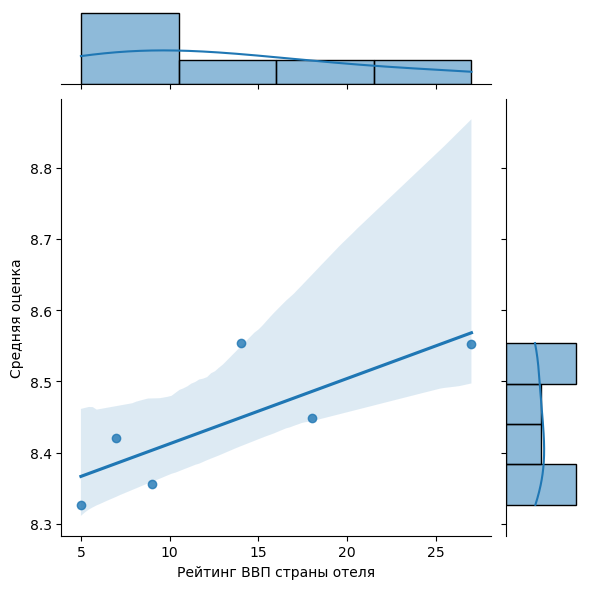

In [23]:
hotel_country_gdp_rank = hotels[hotels['sample']].groupby(
    ['hotel_country_gdp_rank'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=hotel_country_gdp_rank, 
    x='hotel_country_gdp_rank', y='reviewer_score',kind='reg')
plt.xlabel('Рейтинг ВВП страны отеля');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком hotel_country_gdp_rank и целевым признаком reviewer_score: {}%'
      .format(round(hotels[['hotel_country_gdp_rank','reviewer_score']].
                    corr().iloc[0,1] * 100, 3)))

Как ни странно, чем ниже уровень жизни в стране отеля тем выше его оценка. Очень слабая связь с целевым признаком, у данного признака статистическая значимость минимальна.  

In [24]:
# Создаем дискретный признак reviewer_country_gdp_rank рейтинг ВВП страны,
# в которой проживает рецензент
hotels['reviewer_country_gdp_rank'] = hotels.merge(GDP, 
                left_on='reviewer_nationality', right_on='country',
                how='left', validate='m:1')['rank']
# Заполняем не достающие значения в признаке reviewer_country_gdp_rank
index_reviewer_nationality = hotels[hotels['reviewer_nationality']=='Taiwan'].index
hotels.loc[index_reviewer_nationality, 'reviewer_country_gdp_rank'] = 22
hotels['reviewer_country_gdp_rank'] = hotels['reviewer_country_gdp_rank'].fillna(200)
print('Дискретный признак reviewer_country_gdp_rank:')
hotels['reviewer_country_gdp_rank'].describe()


Дискретный признак reviewer_country_gdp_rank:


count    515738.000000
mean         32.679758
std          54.372384
min           2.000000
25%           5.000000
50%           6.000000
75%          31.000000
max         204.000000
Name: reviewer_country_gdp_rank, dtype: float64

Корреляция между признаком reviewer_country_gdp_rank и целевым признаком reviewer_score: 0.866%


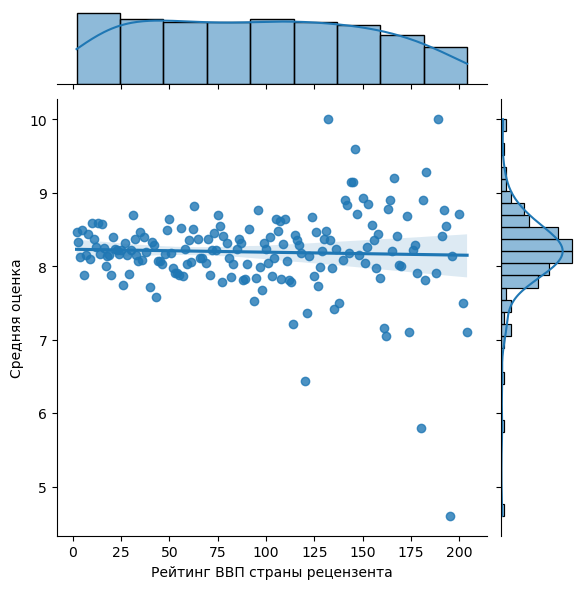

In [25]:
reviewer_country_gdp_rank = hotels[hotels['sample']].groupby(
    ['reviewer_country_gdp_rank'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=reviewer_country_gdp_rank, 
    x='reviewer_country_gdp_rank', y='reviewer_score',kind='reg')
plt.xlabel('Рейтинг ВВП страны рецензента');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком reviewer_country_gdp_rank и целевым признаком reviewer_score: {}%'
      .format(round(hotels[['reviewer_country_gdp_rank','reviewer_score']].
                    corr().iloc[0,1] * 100, 3)))

Признак не имеет никакого влияния  не целевой показатель.

### Создание признака hotel_city_population (население города, в котором расположен отель)

In [26]:
# Загружаем из внешнего датасета справичник популяций по городам
Population = pd.read_csv(
    '/kaggle/input/world-cities-population-cleaned-version/population-cleaned.csv')

In [27]:
# Оставляем в справочнике популяций по городам только те города,
# которые есть в признаке hotel_city
Population = Population[(Population['Country name EN'].isin(
                        hotels['hotel_country'].unique()))&
                       (Population['Name'].isin(
                           hotels['hotel_city'].unique()))]
print('Справочник популяций по городам отелей:')
Population.sort_values('Population',ascending=False)

Справочник популяций по городам отелей:


,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Population,Timezone,LABEL EN,Latitude,Longitude
104983,London,London,"ILondon,LON,Lakana,Landan,Landen,Ljondan,Llund...",GB,United Kingdom,8961989.0,Europe/London,United Kingdom,51.50853,-0.12574
28090,Paris,Paris,"Baariis,Bahliz,Ile-de-France,Lungsod ng Paris,...",FR,France,2138551.0,Europe/Paris,France,48.85341,2.34880
130462,Vienna,Vienna,"Bec,Bech,Becs,Beç,Beč,Bienne,Bécs,Dunaj,VIE,Ve...",AT,Austria,1691468.0,Europe/Vienna,Austria,48.20849,16.37208
15300,Barcelona,Barcelona,"BCN,Barcellona,Barcellonn-a,Barcelona,Barcelon...",ES,Spain,1621537.0,Europe/Madrid,Spain,41.38879,2.15899
65852,Milan,Milan,"Lungsod ng Milano,MIL,Mailand,Mediolan,Mediola...",IT,Italy,1371498.0,Europe/Rome,Italy,45.46427,9.18951
23715,Amsterdam,Amsterdam,"AMS,Aemstelredamme,Aemsterdam,Amestelledamme,A...",NL,Netherlands,741636.0,Europe/Amsterdam,Netherlands,52.37403,4.88969


In [28]:
# Создаем непрерывный признак популяция города 
# на основе справочника популяций по городам 
hotels['hotel_city_population'] = hotels.merge(Population, left_on='hotel_city', 
                                         right_on = 'Name', how='left')['Population']
print('Непрерывный признак city_population:')
hotels['hotel_city_population'].describe()

Непрерывный признак city_population:


count    5.157380e+05
mean     5.304548e+06
std      3.736501e+06
min      7.416360e+05
25%      1.621537e+06
50%      8.961989e+06
75%      8.961989e+06
max      8.961989e+06
Name: hotel_city_population, dtype: float64

### Визуальное сравнение целевого признака reviewer_score и численности населения города отеля

Корреляция между признаком hotel_city_population и целевым признаком reviewer_score: -1.332%


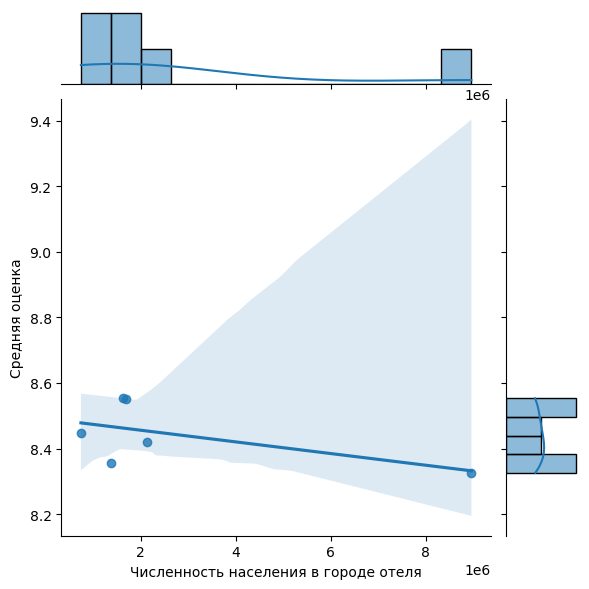

In [29]:
hotel_city_population = hotels[hotels['sample']].groupby(
    ['hotel_city_population'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=hotel_city_population, 
    x='hotel_city_population', y='reviewer_score',kind='reg')
plt.xlabel('Численность населения в городе отеля');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком hotel_city_population и целевым признаком reviewer_score: {}%'
      .format(round(hotels[['hotel_city_population','reviewer_score']].
                    corr().iloc[0,1] * 100, 3)))

С увеличеним населения города отеля незначительно снижается оценка. Корреляция близка к нулю. Статистическая значимость данного признака незначительна.

### Создаем признаки review_day_of_week (день недели размещения отзыва) и review_month (месяц размещения отзыва), на основе признака review_date (дата, когда рецензент разместил соответствующий отзыв)


In [30]:
# Создаем новые номинальные признаки из даты размещения отзыва review_date
hotels['review_day_of_week'] = hotels['review_date'].dt.day_of_week
hotels['review_week']= hotels['review_date'].dt.date.astype('str').apply(
    lambda x: date.fromisoformat(x).isocalendar()[1])
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_quarter'] = hotels['review_date'].dt.quarter
hotels['review_year'] = hotels['review_date'].dt.year
# Переводим признаки в категориальный тип данных
hotels[['review_day_of_week', 'review_week', 'review_month', 
        'review_quarter', 'review_year']] =\
    hotels[['review_day_of_week', 'review_week', 'review_month', 'review_quarter', 
            'review_year']].astype('category')

### Основные статистические характеристики целевого признака reviewer_score, в разрезе по дням недели, месецам, кварталам и годам размещения отзывов

In [31]:
print('Целевой признак reviewer_score, в разрезе года размещения отзывов:')
hotels[hotels['sample']].groupby(
    ['review_year'])['reviewer_score'].describe().round(2)

Целевой признак reviewer_score, в разрезе года размещения отзывов:


,count,mean,std,min,25%,50%,75%,max
review_year,,,,,,,,
2015,70949.0,8.32,1.65,2.5,7.5,8.8,9.6,10.0
2016,198215.0,8.42,1.62,2.5,7.5,8.8,9.6,10.0
2017,117639.0,8.39,1.66,2.5,7.5,8.8,9.6,10.0


In [32]:
print('Целевой признак reviewer_score, в разрезе квартала размещения отзывов:')
hotels[hotels['sample']].groupby(
    ['review_quarter'])['reviewer_score'].describe().round(2)

Целевой признак reviewer_score, в разрезе квартала размещения отзывов:


,count,mean,std,min,25%,50%,75%,max
review_quarter,,,,,,,,
1,91148.0,8.50,1.58,2.5,7.5,9.2,9.6,10.0
2,99123.0,8.40,1.63,2.5,7.5,8.8,9.6,10.0
3,106850.0,8.35,1.66,2.5,7.5,8.8,9.6,10.0
4,89682.0,8.34,1.65,2.5,7.5,8.8,9.6,10.0


In [33]:
print('Целевой признак reviewer_score, в разрезе месяца размещения отзывов:')
hotels[hotels['sample']].groupby(
    ['review_month'])['reviewer_score'].describe().round(2)

Целевой признак reviewer_score, в разрезе месяца размещения отзывов:


,count,mean,std,min,25%,50%,75%,max
review_month,,,,,,,,
1,31512.0,8.48,1.60,2.5,7.5,9.2,9.6,10.0
2,28735.0,8.53,1.56,2.5,7.5,9.2,9.6,10.0
3,30901.0,8.48,1.58,2.5,7.5,8.8,9.6,10.0
4,32213.0,8.43,1.61,2.5,7.5,8.8,9.6,10.0
5,34684.0,8.39,1.64,2.5,7.5,8.8,9.6,10.0
6,32226.0,8.39,1.65,2.5,7.5,8.8,9.6,10.0
7,37141.0,8.34,1.67,2.5,7.5,8.8,9.6,10.0
8,37911.0,8.41,1.63,2.5,7.5,8.8,9.6,10.0
9,31798.0,8.29,1.70,2.5,7.5,8.8,9.6,10.0


In [34]:
print('Целевой признак reviewer_score, в разрезе дня недели размещения отзывов:')
hotels[hotels['sample']].groupby(
    ['review_day_of_week'])['reviewer_score'].describe().round(2)

Целевой признак reviewer_score, в разрезе дня недели размещения отзывов:


,count,mean,std,min,25%,50%,75%,max
review_day_of_week,,,,,,,,
0,60726.0,8.39,1.63,2.5,7.5,8.8,9.6,10.0
1,90954.0,8.44,1.60,2.5,7.5,8.8,9.6,10.0
2,43856.0,8.41,1.63,2.5,7.5,8.8,9.6,10.0
3,55861.0,8.35,1.66,2.5,7.5,8.8,9.6,10.0
4,33447.0,8.37,1.66,2.5,7.5,8.8,9.6,10.0
5,38923.0,8.37,1.66,2.5,7.5,8.8,9.6,10.0
6,63036.0,8.40,1.64,2.5,7.5,8.8,9.6,10.0


Визуально различия средней оценки, разрезе дней недели, месяцев, кварталов и годов, незначительные. На первый взгляд эти категориальные признаки дадут не значительную статистическую значимость. 

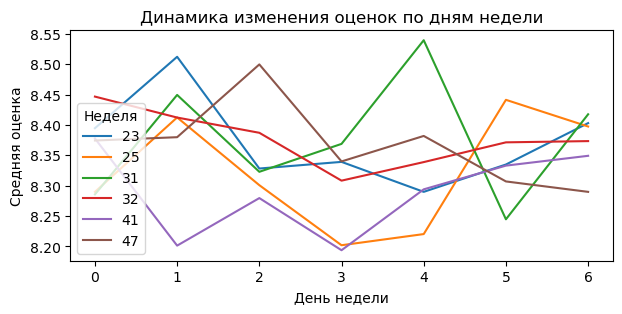

In [35]:
review_week = hotels[(hotels['sample'])&
                    (hotels['review_week'].isin(np.random.randint(0,52,6)))].copy()
review_week['review_week'] = review_week['review_week'].cat.remove_unused_categories()
review_week_grouped = review_week.groupby(
    ['review_week', 'review_day_of_week'],
    as_index=False)['reviewer_score'].mean().copy()
fig, axes = plt.subplots(1, 1, figsize=(7, 3))
sns.lineplot(review_week_grouped, x='review_day_of_week',
             y='reviewer_score', hue='review_week', 
             ax=axes)
axes.set(xlabel='День недели', ylabel='Средняя оценка', 
         title = 'Динамика изменения оценок по дням недели');
plt.legend(title='Неделя', loc='lower left');

Графики средней оценки по дням недели иногда имеют сходство между собой, и поэтому оценка слабо зависит от дня недели.

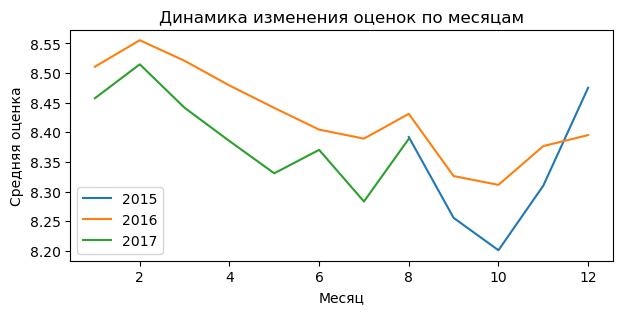

In [36]:
review_date_grouped = hotels[hotels['sample']].groupby(
    ['review_year', 'review_month'],
    as_index=False)['reviewer_score'].mean()
fig, axes = plt.subplots(1, 1, figsize=(7, 3))
sns.lineplot(review_date_grouped, x='review_month',
             y='reviewer_score', hue='review_year', 
             ax=axes)
axes.set(xlabel='Месяц', ylabel='Средняя оценка', 
         title = 'Динамика изменения оценок по месяцам')
plt.legend();

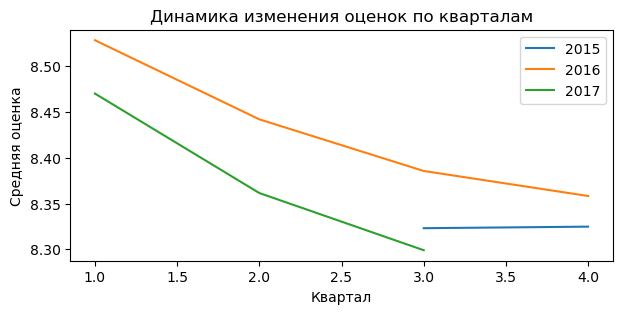

In [37]:
review_date_grouped = hotels[hotels['sample']].groupby(
    ['review_year', 'review_quarter'],
    as_index=False)['reviewer_score'].mean()
fig, axes = plt.subplots(1, 1, figsize=(7, 3))
sns.lineplot(review_date_grouped, x='review_quarter',
             y='reviewer_score', hue='review_year', 
             ax=axes)
axes.set(xlabel='Квартал', ylabel='Средняя оценка', 
         title = 'Динамика изменения оценок по кварталам')
plt.legend();

Средняя оценка коррелируется по месяцам и кварталам, т.е. всплески и падения циклически повторяются из периода в период. Это говорит о том, что оценца в какой-то степени зависит от месяца и квартала. 

### Заполнение пустых значений признаков lat, lng (координаты отелей) на основе признака  hotel_address (адрес отеля) при помощи библиотеки geopy

In [38]:
# Для того чтобы заполнить пустые коодинаты, создаем 
# словарь уникальных адресов (address):(lan,lng), там где нет координат, 
# адрес берется из признака hotel_address, координаты берутся из 
# внешнего источника данных Nominatim geocoder 

geolocator = Nominatim(user_agent="SF_agent")
hotels_coordinates_is_na = hotels[(hotels['lat'].isna())|(hotels['lng'].isna())]
index_coordinates_is_na = hotels_coordinates_is_na.index
hotel_address_groups = hotels_coordinates_is_na.groupby(
                                ['hotel_address']).groups
dict_address = {}
for index, hotel_address in enumerate(hotel_address_groups):
        # Убираем из адреса одиночные буквы
        hotel_address_truncated = ' '.join(re.findall(
            r'\b[A-Za-z0-9]{2,}\b', hotel_address))
        # Вызываем geocode до тех пор пока он не выдаст результат с координатами
        # Для решения проблемы связанной с ошибкой:
        # GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443
        # заключаем вызов метода geocode в блок try except 
        # и выполняем его до тех пор пока вызов метода не пройдет успешно
        location = None
        while location is None:
            except_ = True
            while except_:
                try:
                    except_ = False
                    location = geolocator.geocode(hotel_address_truncated)
                except:
                    except_ = True
            # Если вызов geocode не дал результата,
            # тогда убираем первое слово в адресе
            if location is None:
                hotel_address_truncated = ' '.join(
                    hotel_address_truncated.split(' ')[1:])
        loc_dict = location.raw
        lat = float(loc_dict['lat'])
        lng = float(loc_dict['lon'])
        dict_address[hotel_address] = (lat,lng)
        s = (str(index + 1) + '/' + str(len(hotel_address_groups)) + ' ' +
             hotel_address + ' -> ' + hotel_address_truncated)
        print(s, end='\r')

In [39]:
# Заполняем пустые ячейки в признаках lat и lng из словаря (address):(lan,lng)
hotels.loc[index_coordinates_is_na,'lat'] = (
    hotels_coordinates_is_na['hotel_address'].apply(lambda x: dict_address[x][0]))
hotels.loc[index_coordinates_is_na,'lng'] = (
    hotels_coordinates_is_na['hotel_address'].apply(lambda x: dict_address[x][1]))
print('Признаки lat и lng заполнены полностью:')
hotels[['lat', 'lng']].info()

Признаки lat и lng заполнены полностью:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     515738 non-null  float64
 1   lng     515738 non-null  float64
dtypes: float64(2)
memory usage: 7.9 MB


### Создание признака km_from_reviewer_nationality_to_hotel (расстояние от страны рецензента до отеля) на основании признаков reviewer_nationality (страна рецензента), lat и lng (координаты отеля) при помощи библиотеки geopy

In [40]:
# Создаем cловарь уникальных стран рецензентов (reviewer_nationality):(lan,lng), 
# координаты берутся из внешнего источника данных Nominatim geocoder 

reviewer_nationality_groups = hotels[
    hotels['reviewer_nationality']!=''].groupby(['reviewer_nationality']).groups
dict_reviewers_nationalities = {}
for index, reviewer_nationality in enumerate(reviewer_nationality_groups):
        # Вызываем geocode до тех пор пока он не выдаст результат с координатами
        # Для решения проблемы связанной с ошибкой:
        # GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443
        # заключаем вызов метода geocode в блок try except 
        # и выполняем его до тех пор пока вызов метода не пройдет успешно
        except_ = True
        while except_:
            try:
                except_ = False
                location = geolocator.geocode(reviewer_nationality)
            except:
                except_ = True
        loc_dict = location.raw
        lat = float(loc_dict['lat'])
        lng = float(loc_dict['lon'])
        dict_reviewers_nationalities[reviewer_nationality] = (lat,lng)
        s = str(index + 1) + '/' + str(len(reviewer_nationality_groups))
        print(s, end='\r')

In [41]:
# Создаем словарь уникальных сочетаний страна рецензента и координаты отеля
# (reviewer_nationality, lat, lng):km 
# на основе словаря уникальных стран рецензентов (reviewer_nationality):(lan, lng) и
# признаков, lat, lng, путем вычисления дистанции между страной рецензента и
# координатами отеля при помощи метода distance.distance библиотеки geopy
reviewer_nationality_lat_lng_groups = hotels[
    hotels['reviewer_nationality']!=''].groupby(['reviewer_nationality','lat','lng']).groups
dict_distances = {}
for reviewer_nationality, lat, lng in reviewer_nationality_lat_lng_groups:
    dict_distances[reviewer_nationality, lat, lng] = distance.distance(
        (dict_reviewers_nationalities[reviewer_nationality][0],
         dict_reviewers_nationalities[reviewer_nationality][1]),
        (lat, lng)).km
    

In [42]:
# Создаем новый непрерывный признак km_from_reviewer_nationality_to_hotel на основе
# словаря уникальных сочетаний страна рецензента и координаты отеля
# (reviewer_nationality, lat, lng):km 
def get_km_from_reviewer_nationality_to_hotel(feature):
    if feature[0] == '':
        return 0
    else:
        return dict_distances[feature[0],feature[1],feature[2]]
hotels['km_from_reviewer_nationality_to_hotel'] =\
    hotels[['reviewer_nationality','lat','lng']].\
    apply(get_km_from_reviewer_nationality_to_hotel, axis=1)
print('Непрерывный признак km_from_reviewer_nationality_to_hotel:')
hotels['km_from_reviewer_nationality_to_hotel'].describe()

Непрерывный признак km_from_reviewer_nationality_to_hotel:


count    515738.000000
mean       3203.947361
std        4091.391303
min           0.000000
25%         413.405821
50%         802.799939
75%        5942.852187
max       19248.580769
Name: km_from_reviewer_nationality_to_hotel, dtype: float64

Корреляция между признаком km_from_reviewer_nationality_to_hotel и целевым признаком reviewer_score: 0.406%


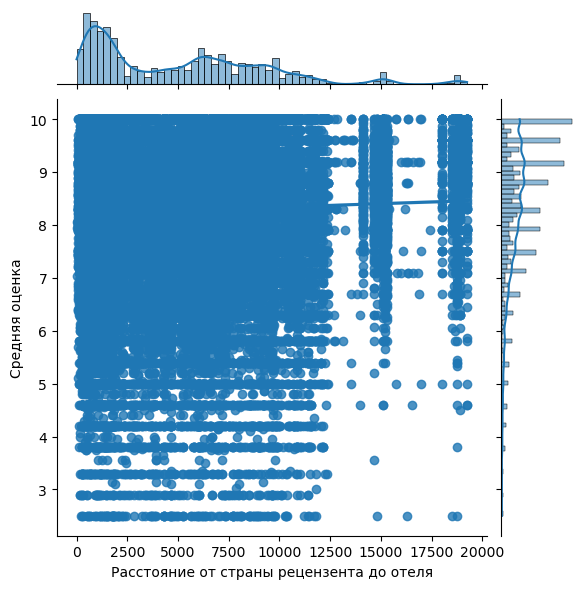

In [43]:
km_from_reviewer_nationality_to_hotel = hotels[hotels['sample']].groupby(
    ['km_from_reviewer_nationality_to_hotel'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=km_from_reviewer_nationality_to_hotel, 
    x='km_from_reviewer_nationality_to_hotel', y='reviewer_score', kind='reg')
plt.xlabel('Расстояние от страны рецензента до отеля');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком km_from_reviewer_nationality_to_hotel и целевым признаком reviewer_score: {}%'
      .format(round(hotels[['km_from_reviewer_nationality_to_hotel','reviewer_score']].
                    corr().iloc[0,1] * 100, 3)))

Визуально, зафиксировано слабое влияние расстояния от страны рецензента до отеля на целевой признак. Корреляция этих двух признаков практически отсутствует.

### Преобразование признака reviewer_nationality (страна рецензента)

In [44]:
# Объявляем вспомогательную функцию по уменьшению количества уникальных категорий.
# Попутно признак переводится в категориальный тип данных
def feture_transformation(df, feature, max_cat = 30,
                          transform = True) -> None:
    '''
    Определяем число популярных категорий признака feature в датасете df 
    таким образом, чтобы эти категории были в количестве не более max_cat.
    Если Transform = False тогда выводиться только информация о признаке
    feature без преобразования. 
    '''
    nlargest = 0
    nlargest_sum = 0
    print('Количество категорий признака {}: {}'.format(feature, df[feature].nunique()))
    while (nlargest < max_cat and nlargest < df[feature].nunique()):
        nlargest += 1
        nlargest_sum = df[
            feature].value_counts().nlargest(
            nlargest).sum()

    print(
        'Количество популярных категорий признака {}, которые покрывают {}% данных: {}'.
        format(feature, round(nlargest_sum / df.shape[0] * 100, 2), nlargest))

    # Создадим список популярных категорий признака feature
    popular_categories = df[feature].value_counts().nlargest(nlargest).index
    print('Cписок популярных категорий признака {}: \n{}'.format(feature,
                                                                 popular_categories))
    if transform:
        # Присвоим категорию оther стокам не вошедшим в список популярных категирий
        # Попутно удаляем пробелы в начале и в конце строки признака
        df[feature] = df[feature].apply(lambda x: 
                str(x).strip() if x in popular_categories else 'other')
        # Переводим признак feature в категориальный тип данных
        df[feature] = df[feature].astype('category')
        df[feature] = df[feature].cat.remove_unused_categories()

In [45]:
# Уменьшаем количество уникальный категорий в признаке reviewer_nationality, 
# переводим признак в категориальный тип данных
feture_transformation(hotels, 'reviewer_nationality', max_cat=14)

Количество категорий признака reviewer_nationality: 227
Количество популярных категорий признака reviewer_nationality, которые покрывают 76.73% данных: 14
Cписок популярных категорий признака reviewer_nationality: 
Index(['United Kingdom', 'United States of America', 'Australia', 'Ireland',
       'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland',
       'Germany', 'Canada', 'France', 'Israel', 'Italy', 'Belgium'],
      dtype='object')


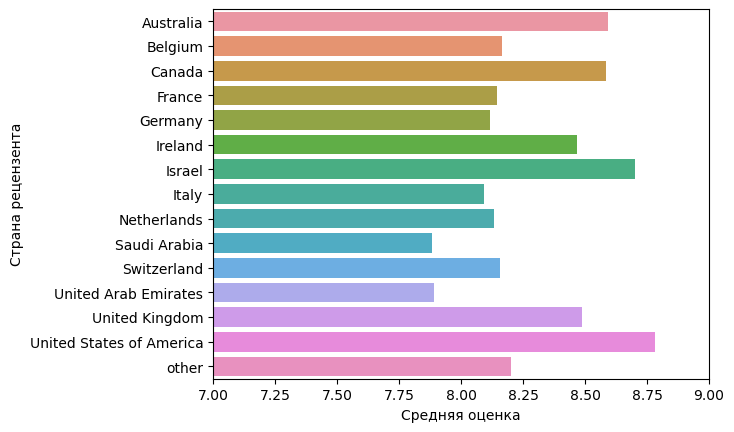

In [46]:
reviewer_nationality = hotels[hotels['sample']].groupby(
    ['reviewer_nationality'],
    as_index=False)['reviewer_score'].mean()
ax = sns.barplot(data=reviewer_nationality, 
    y='reviewer_nationality', x='reviewer_score', orient='h')
ax.set_xlim(7,9)
plt.xlabel('Средняя оценка');
plt.ylabel('Страна рецензента');

Визуально, средняя оценка имеет взаимоствязь с целевым признаком

### Создание признаков силы тональности наименования отеля, отрицательного и положительного отзыва: 
* hotel_name_neg, hotel_name_neu,
hotel_name_pos, hotel_name_compound (баллы тональности наименования отеля);
* negative_review_neg, negative_review_neu, negative_review_pos, negative_review_compound (баллы тональности негативного отзыва); 
* positive_review_neg, positive_review_neu, positive_review_pos, positive_review_compound (баллы тональности позитивного отзыва),
### на основе признаков hotel_name (название отеля), negative_review (отрицательный отзыв, который рецензент дал отелю), positive_review (положительный отзыв, который рецензент дал отелю) 

In [47]:
# Если оставить строку No negative в признаке negative_review,
# то баллы тональности будут иметь негативный характер. 
# Поэтому в таких случаях присваиваем строку nothing (ничего)
# признаку negative_review, т.е. баллы тональности будут
# иметь нейтральный характер.
no_negative_index = hotels[hotels['negative_review'].\
                           str.lower().str.strip().\
                           isin(['no negative'])].index
hotels.loc[no_negative_index, ['negative_review']] = 'nothing' 
# То же самое делаем с признаком positive_review
no_positive_index = hotels[hotels['positive_review'].\
                           str.lower().str.strip().\
                           isin(['no positivee'])].index
hotels.loc[no_positive_index, ['positive_review']] = 'nothing'

In [48]:
# Создаем лист словарей наименований отелей, позитивных и негативных отзывов 
# (text):(neg, neu, pos, compound), 
# текст берется из признаков hotel_name, negative_review и positive_review, 
# оценки берутся при помощи класса SentimentIntensityAnalyzer библиотеки nltk

nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

lst_dicts_texts = [{}, {}, {}]
lst_level_texts =\
    [list(hotels['hotel_name'].str.lower().str.strip().unique()),
    list(hotels['negative_review'].str.lower().str.strip().unique()),
    list(hotels['positive_review'].str.lower().str.strip().unique())]
dict_keys = {1: 'negative', 2: 'positive'}
for level, lst_texts in enumerate(lst_level_texts):
    for index, text in enumerate(lst_texts):
        score = sent_analyzer.polarity_scores(text)
        # Если негативный отзыв имеет только нейтральную окрасу и
        # в отзыве нет слова nothing,
        # то в признаке negative_review добавляем негативную окраску, 
        # а в признаке positive_review позитивную
        if level:
            if not re.findall(r'nothing', text):
                if score['neu'] and not score['neg'] + score['pos']:
                    score = sent_analyzer.polarity_scores(
                        'on the ' + dict_keys[level] + ' side is ' + text)
        lst_dicts_texts[level][text] = (score['neg'], score['neu'], score['pos'], score['compound'])
        s = str(level + 1) + ' / 3; ' + str(index + 1) + ' / ' + str(len(lst_texts)) + '   '
        print(s, end='\r')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
# Создаем новые непрерывные признаки: 
#   hotel_name_neg, hotel_name_neu, 
#   hotel_name_pos, hotel_name_compound, 
#   negative_review_neg, negative_review_neu, 
#   negative_review_pos, negative_review_compound, 
#   positive_review_neg, positive_review_neu, 
#   positive_review_pos, positive_review_compound, 
# на основе словаря (text):(neg, neu, pos, compound)
def get_text_score(feature):
    return (lst_dicts_texts[0][feature[0].lower().strip()],
            lst_dicts_texts[1][feature[1].lower().strip()],
            lst_dicts_texts[2][feature[2].lower().strip()])

srs_country_city = hotels[['hotel_name',
                            'negative_review',
                            'positive_review']].apply(
                                    get_text_score, axis=1)
hotels[['hotel_name_neg', 'hotel_name_neu',
        'hotel_name_pos', 'hotel_name_compound',
        'negative_review_neg', 'negative_review_neu',
        'negative_review_pos', 'negative_review_compound',
        'positive_review_neg', 'positive_review_neu',
        'positive_review_pos', 'positive_review_compound']] =\
                        pd.DataFrame(map(lambda x: x[0] + x[1] + x[2],
                                         srs_country_city))
print('Непрерывные признаки силы тональности:')
hotels[['hotel_name_neg', 'hotel_name_neu',
        'hotel_name_pos', 'hotel_name_compound',
        'negative_review_neg', 'negative_review_neu',
        'negative_review_pos', 'negative_review_compound',
        'positive_review_neg', 'positive_review_neu',
        'positive_review_pos', 'positive_review_compound']].describe()

Непрерывные признаки силы тональности:


,hotel_name_neg,hotel_name_neu,hotel_name_pos,hotel_name_compound,negative_review_neg,negative_review_neu,negative_review_pos,negative_review_compound,positive_review_neg,positive_review_neu,positive_review_pos,positive_review_compound
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.000380,0.930150,0.069470,0.070054,0.127292,0.814457,0.052880,-0.147693,0.034850,0.529954,0.434607,0.671698
std,0.013709,0.171872,0.171478,0.177119,0.153503,0.179886,0.115442,0.408394,0.103436,0.223259,0.183115,0.248488
min,0.000000,0.208000,0.000000,-0.599400,0.000000,0.000000,0.000000,-0.998200,0.000000,0.000000,0.000000,-0.983200
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.709000,0.000000,-0.571900,0.000000,0.408000,0.301000,0.557400
50%,0.000000,1.000000,0.000000,0.000000,0.079000,0.833000,0.000000,0.000000,0.000000,0.581000,0.419000,0.708900
75%,0.000000,1.000000,0.000000,0.000000,0.222000,1.000000,0.057000,0.000000,0.000000,0.690000,0.588000,0.883400
max,0.500000,1.000000,0.792000,0.812600,1.000000,1.000000,1.000000,0.996400,1.000000,1.000000,1.000000,0.999200


### Создание признака hotel_name_address (название отеля и адрес - уникальный индентификатор отеля)

In [50]:
# Создаем признак hotel_name_address путем сложения признаков hotel_name и hotel_address
hotels['hotel_name_address'] = hotels[['hotel_name',
                                'hotel_address']].apply(
                                lambda x: x[0]+'_'+x[1], axis=1)
print('Категориальный признак hotel_name_address:')
hotels['hotel_name_address'].describe()

Категориальный признак hotel_name_address:


count                                                515738
unique                                                 1494
top       Britannia International Hotel Canary Wharf_163...
freq                                                   4789
Name: hotel_name_address, dtype: object

In [51]:
# Уменьшаем количество уникальный категорий в признаке hotel_name_address, 
# переводим признак в категориальный тип данных
feture_transformation(hotels, 'hotel_name_address', max_cat=510)

Количество категорий признака hotel_name_address: 1494
Количество популярных категорий признака hotel_name_address, которые покрывают 74.86% данных: 510
Cписок популярных категорий признака hotel_name_address: 
Index(['Britannia International Hotel Canary Wharf_163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom',
       'Strand Palace Hotel_372 Strand Westminster Borough London WC2R 0JJ United Kingdom',
       'Park Plaza Westminster Bridge London_Westminster Bridge Road Lambeth London SE1 7UT United Kingdom',
       'Copthorne Tara Hotel London Kensington_Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom',
       'DoubleTree by Hilton Hotel London Tower of London_7 Pepys Street City of London London EC3N 4AF United Kingdom',
       'Grand Royale London Hyde Park_1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom',
       'Holiday Inn London Kensington_Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom',
   

### Создание непрерывного признака tags_weight (вес тегов)

In [52]:
# Сколько уникальных тегов представлено в наборе данных?
dict_tags = dict()
for str_tags in hotels['tags']:
    lst_tags = re.findall(r"' ([ A-Za-z0-9]+) '", str_tags)
    for tag in lst_tags:
        if dict_tags.get(tag) is None:
            dict_tags[tag] = 1
        else:
            dict_tags[tag] += 1
print('Уникальных тегов представлено в наборе данных:', len(dict_tags))

Уникальных тегов представлено в наборе данных: 2428


In [53]:
# Какие теги представлены в наибольшем числе отзывов?
print('Топ 10 тегов в представленных отзывах:')
# Сортируем словарь по значениям
sorted(list(dict_tags.items()), key=lambda x: x[1], reverse=True)[:10]

Топ 10 тегов в представленных отзывах:


[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015)]

In [54]:
# Создаем новый непрерывный признак tags_weight (вес тегов), 
# вычисляется путем сложения частоты повторений тегов в признаке tags
def get_tags_weight(feature):
    tags_weight = 0
    lst_tags = re.findall(r"' ([ A-Za-z0-9]+) '", feature)
    for tag in lst_tags:
        tags_weight += dict_tags[tag] 
    return tags_weight

hotels['tags_weight'] = hotels['tags'].apply(get_tags_weight)
print('Непрерывный признак tags_weight:')
hotels['tags_weight'].describe()

Непрерывный признак tags_weight:


count    5.157380e+05
mean     8.413210e+05
std      2.512663e+05
min      2.955700e+04
25%      6.773360e+05
50%      8.679220e+05
75%      1.047922e+06
max      1.207969e+06
Name: tags_weight, dtype: float64

Корреляция между признаком tags_weight и целевым признаком reviewer_score: 3.105%


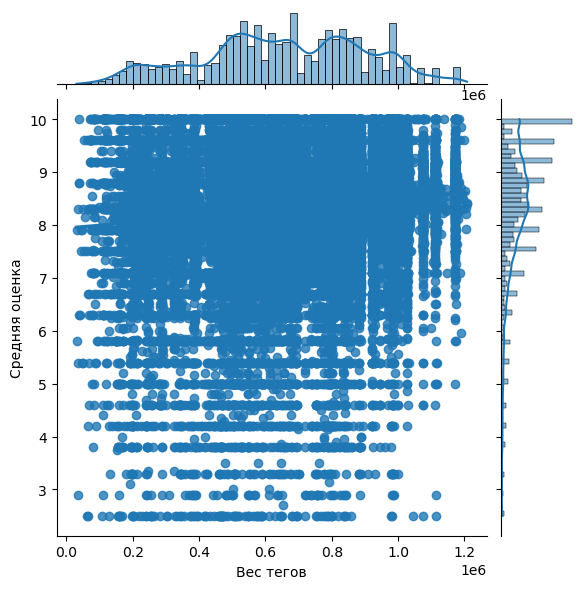

In [55]:
tags_weight = hotels[hotels['sample']].groupby(
    ['tags_weight'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=tags_weight, 
    x='tags_weight', y='reviewer_score', kind='reg')
plt.xlabel('Вес тегов');
plt.ylabel('Средняя оценка');
print('Корреляция между признаком tags_weight и целевым признаком reviewer_score: {}%'
      .format(round(hotels[['tags_weight','reviewer_score']].corr().iloc[0,1] * 100, 3)))

Фиксируем слабую связь между весом тегов и целевым признаком. Чем популярнее теги, которые рецензент дал отелю, тем выше оценка. 

### Создание признаков, детально описывающих поездку: 
* with_a_pet (отдых с домашним питомцем),
* trip_type (тип путешествия: деловая поезка или отдых), 
* travelers (количество путешествинников: одиночка, пара, семья с ребенком, группа),
* number_of_nights (количество ночей), 
* mobile (регистрация с мобильного телефона),
* room_description (временный признак - описание гостиничного номера, позднее подлежит разложению на несколько новых признаков, но об этом позднее),
### перечиленные признаки извлекаются из исходного признака tags (теги, которые рецензент дал отелю)

In [56]:
# Создаем новые номинальные признаки: 
# trip_type, travelers, room_description, number_of_nights
# бинарные with_a_pet, mobile
# путем извлечения регулярных выражений из признака tags
def get_new_features(feature):
    dict_result = {'with_a_pet': 0, 'trip_type': 'unknown', 'travelers': 'unknown',
                   'number_of_nights': None, 'mobile': 0, 'room_description': 'unknown'}
    begin_room_type, end_room_type = 0, 0
    found = re.search(r'with a pet', feature, flags = re.IGNORECASE)
    if found is not None:
        dict_result['with_a_pet'] = 1
        begin_room_type = found.span()[1]
    found = re.search(r'\w+ trip\b', feature, flags = re.IGNORECASE)
    if found is not None:
        dict_result['trip_type'] = found.group(0)
        begin_room_type = found.span()[1]
    found = re.search(
        r"' Solo traveler '|' Couple '|' Travelers with friends '|' Family with \w+ children '|' Group '",
        feature, flags = re.IGNORECASE)
    if found is not None:
        dict_result['travelers'] = found.group(0)[2:-2]
        begin_room_type = found.span()[1]
    found = re.search(r'Submitted from a mobile device', feature, flags = re.IGNORECASE)       
    if found is not None:
        dict_result['mobile'] = 1
        end_room_type = found.span()[0]
    found = re.search(r'\d+ night', feature)
    if found is not None:
        dict_result['number_of_nights'] = int(found.group(0).split(' ')[0])
        end_room_type = found.span()[0]
    found = re.findall(r"' ([A-Za-z0-9 ]+) '", feature[begin_room_type:end_room_type])
    if found:
        dict_result['room_description'] = found[0]
    return list(map(lambda x: x[1], dict_result.items()))
hotels[['with_a_pet', 'trip_type', 'travelers',
        'number_of_nights', 'mobile', 'room_description']] =\
        hotels['tags'].apply(get_new_features).to_list()

In [57]:
# Если в путешествии была пара или друзья или семья или с домашним питомцем или 
# номер не бизнес-класса, то скорее всего это поездка на отдых, 
# тогда в этих случаях присваиваем вместо значений unknown 
# признака trip_type значение Leisure trip
index_trip_type_is_unknown = hotels[hotels['trip_type']=='unknown'].index
print('Количество примеров с неизвестным значением признака trip_type:',
     hotels[hotels['trip_type']=='unknown'].shape[0])
hotels.loc[index_trip_type_is_unknown, 'trip_type'] = \
    hotels.loc[index_trip_type_is_unknown,
 ['with_a_pet','travelers','tags']].apply(lambda x: 'Leisure trip' 
    if x[0] or (x[1] in 
    ('Couple', 'Travelers with friends', 'Family with young children', 
    'Family with older children') or not 'business' in x[2].lower()) 
                                          else 'unknown', axis=1)
print('После преобразования:',
     hotels[hotels['trip_type']=='unknown'].shape[0])
# Переводим строчные признаки в категориальный тип данных
hotels[['trip_type','travelers']] =\
            hotels[['trip_type','travelers']].astype('category')

Количество примеров с неизвестным значением признака trip_type: 15021
После преобразования: 15


In [58]:
print('Категориальные признаки trip_type и travelers:')
hotels[['trip_type','travelers']].value_counts()

Категориальные признаки trip_type и travelers:


trip_type      travelers                 
Leisure trip   Couple                        238071
               Family with young children     58755
Business trip  Solo traveler                  58279
Leisure trip   Group                          58130
               Solo traveler                  50254
               Family with older children     25632
Business trip  Couple                         14223
               Group                           7259
               Family with young children      2260
Leisure trip   Travelers with friends          1942
Business trip  Family with older children       717
               Travelers with friends           201
unknown        Solo traveler                     12
               Group                              3
dtype: int64

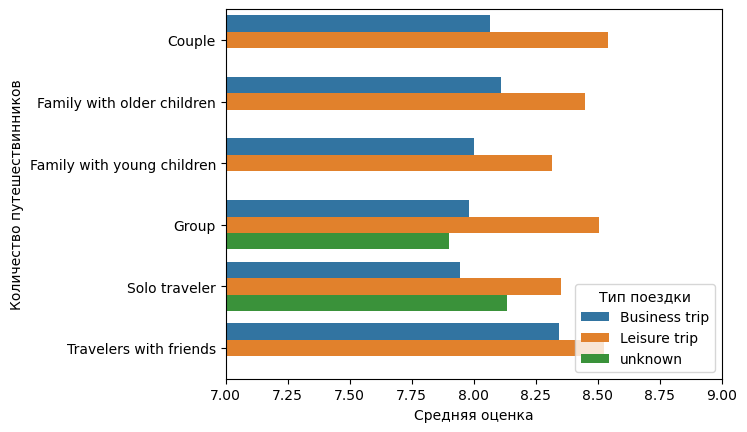

In [59]:
room_type = hotels[hotels['sample']].groupby(
    ['trip_type', 'travelers'],
    as_index=False)['reviewer_score'].mean()
ax = sns.barplot(data=room_type, 
    y='travelers', x='reviewer_score', hue='trip_type', orient='h')
ax.set_xlim(7,9)
plt.xlabel('Средняя оценка')
plt.ylabel('Количество путешествинников')
plt.legend(title='Тип поездки');

Визуально оценка зависит от того деловая ли это поезка или отпуск, а так же от величины компании путешественников.

In [60]:
# Заполняем пустые значения признака number_of_nights модой
hotels['number_of_nights'] = hotels['number_of_nights'].fillna(
    hotels['number_of_nights'].mode()[0])
print('Дискретный признак number_of_nights:')
hotels['number_of_nights'].value_counts().nlargest(9)

Дискретный признак number_of_nights:


1.0    193836
2.0    133936
3.0     95825
4.0     47817
5.0     20843
6.0      9776
7.0      7399
8.0      2502
9.0      1293
Name: number_of_nights, dtype: int64

In [61]:
# Отразим наиболее популярные уникальные категории признака number_of_nights
feture_transformation(hotels, 'number_of_nights', max_cat=9, transform=True)

Количество категорий признака number_of_nights: 31
Количество популярных категорий признака number_of_nights, которые покрывают 99.51% данных: 9
Cписок популярных категорий признака number_of_nights: 
Float64Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')


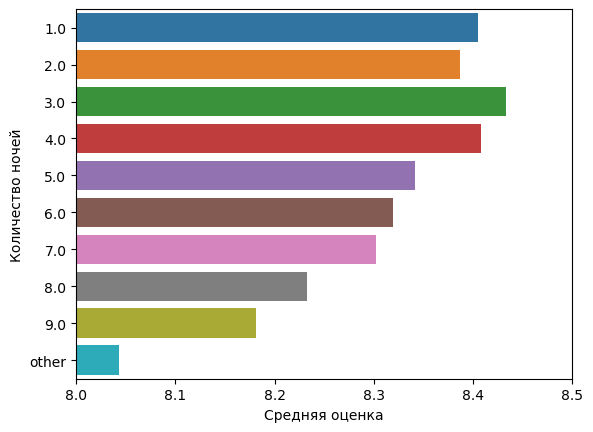

In [62]:
number_of_nights = hotels[hotels['sample']].groupby(
    ['number_of_nights'],
    as_index=False)['reviewer_score'].mean().copy()
number_of_nights['number_of_nights'] = number_of_nights['number_of_nights'].astype('category')
number_of_nights['number_of_nights'].cat.remove_unused_categories()
ax = sns.barplot(data=number_of_nights, 
    y='number_of_nights', x='reviewer_score', orient='h')
ax.set_xlim(8,8.5)
plt.xlabel('Средняя оценка')
plt.ylabel('Количество ночей');
#plt.legend(title='Тип поездки');

Визуально наблюдаем незначительную взаимосвязь количества ночей с целевым признаком.

In [63]:
# Отразим наиболее популярные уникальные категории признака room_description
feture_transformation(hotels, 'room_description', max_cat=127, transform=False)

Количество категорий признака room_description: 2387
Количество популярных категорий признака room_description, которые покрывают 83.53% данных: 127
Cписок популярных категорий признака room_description: 
Index(['Double Room', 'Standard Double Room', 'Superior Double Room',
       'Deluxe Double Room', 'Double or Twin Room',
       'Standard Double or Twin Room', 'Classic Double Room',
       'Superior Double or Twin Room', '2 rooms', 'Standard Twin Room',
       ...
       'Deluxe with Two Double Beds', 'Double Deluxe Room',
       'Comfort Triple Room', 'Superior Room with 2 Single Beds',
       'Club Single Room', 'Double Room with Spa Bath',
       'Double or Twin Ground Floor', 'Double or Twin Room with Spa Access',
       'Deluxe King Room with City View',
       'Deluxe King Room with Stadium View'],
      dtype='object', length=127)


### Создание булевых признаков, индикаторов присутсвия наиболее часто встречающихся слов в признаке room_description (временный признак - описание гостиничного номера)

In [64]:
# Изучим наиболее популярные слова встречающиеся в признаке room_description 
lst_words = [r'child', r'queen', 
            r'(?:non|no|without) \b[A-Za-z]+\b',
            r'\b(?!(?:to|bed|beds|size|in|at|with|one|two|or|and))[A-Za-z]+\b']
pattern_words = '|'.join(lst_words)
dict_words = {}
for tag in hotels['room_description'].values:
    found = re.findall(r''+pattern_words, tag, flags = re.IGNORECASE)
    for word in found:
        word = word.lower()
        if dict_words.get(word) == None:
            dict_words[word] = 1
        else:
            dict_words[word] += 1
dict_words = dict(sorted(dict_words.items(),
                       key=lambda x: x[1], reverse=True)[:90])
print('Топ-90 слов в признаке room_description:')
dict_words

Топ-90 слов в признаке room_description:


{'room': 467435,
 'double': 305314,
 'twin': 135024,
 'standard': 87347,
 'superior': 86157,
 'deluxe': 65883,
 'king': 36878,
 'classic': 36023,
 'queen': 31200,
 'single': 27203,
 'executive': 19536,
 'view': 18004,
 'suite': 17266,
 'guest': 13902,
 'rooms': 13769,
 'adults': 10948,
 'triple': 9610,
 'club': 9360,
 'family': 8617,
 'comfort': 7760,
 'access': 7732,
 'junior': 7706,
 'small': 6519,
 'studio': 6414,
 'city': 6127,
 'sofa': 5068,
 'hilton': 4505,
 'non smoking': 4414,
 'spa': 3803,
 'balcony': 3468,
 'basic': 3289,
 'luxury': 2935,
 'child': 2864,
 'lounge': 2506,
 'without window': 2497,
 'cosy': 2311,
 'terrace': 2304,
 'large': 2243,
 'guestroom': 2077,
 'premium': 2055,
 'premier': 1984,
 'river': 1855,
 'quadruple': 1824,
 'apartment': 1791,
 'economy': 1661,
 'eiffel': 1571,
 'courtyard': 1566,
 'extra': 1461,
 'free': 1319,
 'special': 1259,
 'offer': 1207,
 'bath': 1142,
 'privilege': 1125,
 'business': 1124,
 'compact': 1089,
 'canal': 1055,
 'barlow': 1054,
 

In [78]:
lst_top_words = list(dict_words)
def get_binary_top_words(feature):
    result = [0] * len(lst_top_words)
    for index, word in enumerate(lst_top_words):
        if word in feature.lower():
            result[index] = 1
    return result
lst_features_top_words = list(map(lambda x: 'top_word_' + x, lst_top_words))
hotels[lst_features_top_words] =\
    hotels['room_description'].apply(get_binary_top_words).to_list()

In [79]:
# Переводим числовые признаки в булевой тип данных
boolean_features = ['with_a_pet', 'mobile'] + lst_features_top_words
hotels[boolean_features] = hotels[boolean_features].astype('bool')

In [80]:
# Объединяем одинаковые признаки
hotels['top_word_disability'] = \
    hotels[['top_word_disability', 'top_word_accessible']].apply(
            lambda x: x[0] | x[1], axis=1)
hotels['top_word_without window'] = \
    hotels[['top_word_without window', 'top_word_no window']].apply(
            lambda x: x[0] | x[1], axis=1)
hotels = hotels.drop(['top_word_accessible', 'top_word_no window'], axis=1)
boolean_features.remove('top_word_accessible')
boolean_features.remove('top_word_no window')

In [81]:
print('Булевые признаки:')
hotels[hotels['sample']][boolean_features].describe().T.sort_values('freq')

Булевые признаки:


,count,unique,top,freq
top_word_double,386803,2,True,227441
mobile,386803,2,True,230778
top_word_twin,386803,2,False,285476
top_word_standard,386803,2,False,321304
top_word_superior,386803,2,False,322158
...,...,...,...,...
top_word_public,386803,2,False,386507
top_word_transport,386803,2,False,386507
top_word_shower,386803,2,False,386520
top_word_quality,386803,2,False,386520


In [82]:
dict_df = {}
for feature in boolean_features:
    df = hotels[hotels['sample']].groupby(
    [feature], as_index=False)['reviewer_score'].mean()
    df = df.rename(columns = {feature: 'There_is'})
    df['feature'] = feature
    dict_df[feature] = df

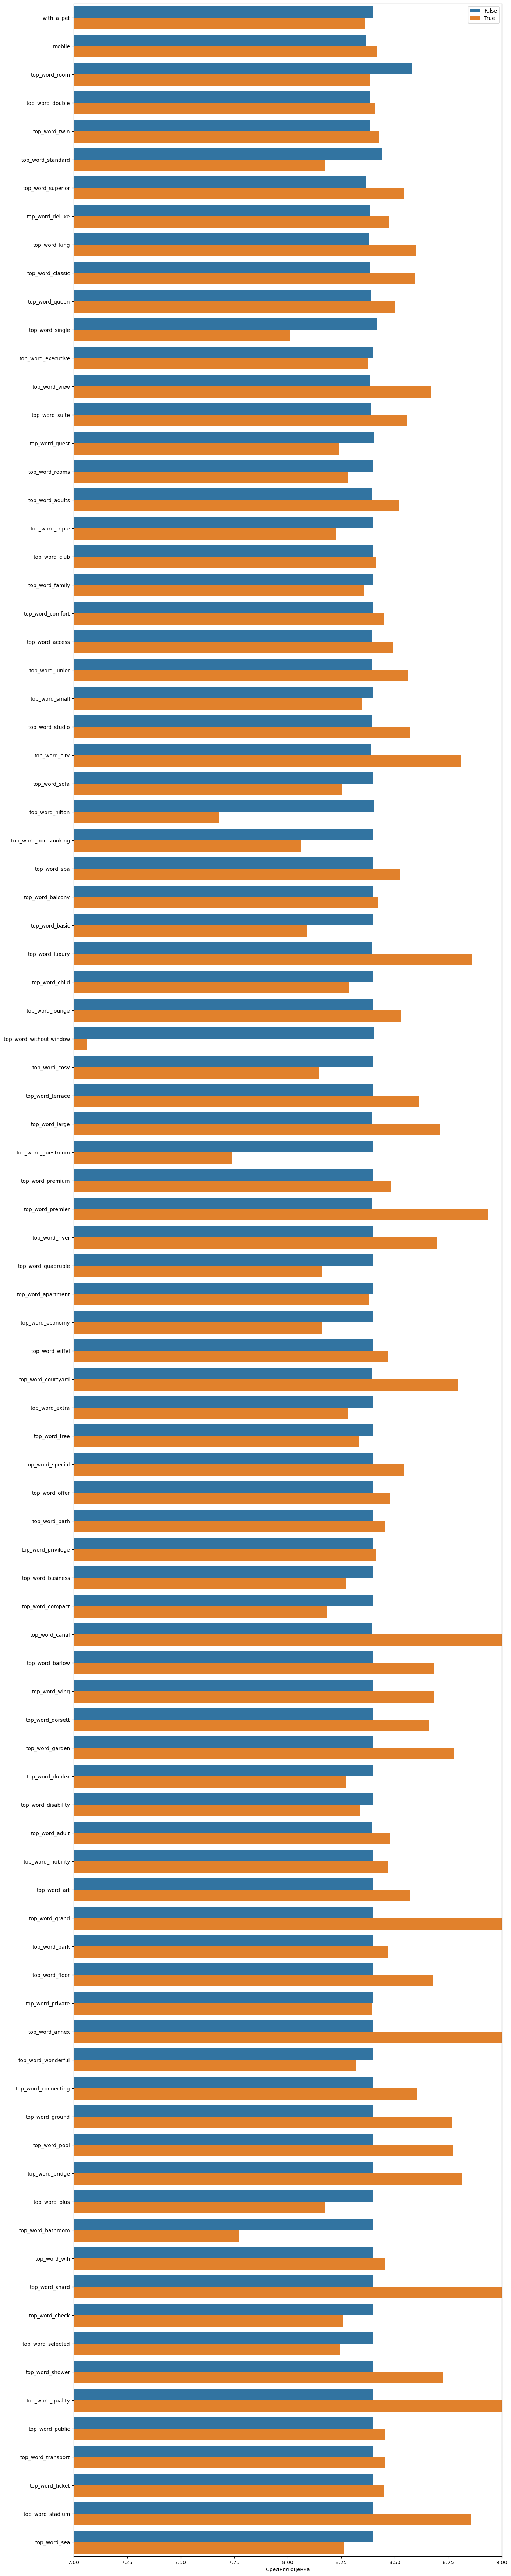

In [83]:
concat_boolean_features = pd.concat(map(lambda x: x[1], dict_df.items()))
plt.subplots(1, 1, figsize=(15, len(boolean_features)))
ax = sns.barplot(data=concat_boolean_features, y='feature', x='reviewer_score', 
            hue='There_is', orient='h')
ax.set_xlim(7,9)
ax.set_xlabel('Средняя оценка')
ax.set_ylabel('')
ax.legend(title='');

In [84]:
print('Корреляция булевых признаков с целевым признаком reviewer_score:')
(hotels[boolean_features + ['reviewer_score']].corr(method='spearman')\
                ['reviewer_score'].iloc[0:-1] * 100).sort_values().\
                round(2).astype('str') + '%'

Корреляция булевых признаков с целевым признаком reviewer_score:


top_word_standard          -3.75%
top_word_single            -3.34%
top_word_without window    -3.02%
top_word_hilton            -2.12%
top_word_room              -1.73%
                            ...  
top_word_city               1.84%
mobile                      2.03%
top_word_view               2.07%
top_word_king               2.46%
top_word_superior            2.5%
Name: reviewer_score, Length: 90, dtype: object

Очевидно, что чем больше разница в средней оценке между True и False и чем менее разница в долях True и False тем выше статистичечкая значимость.

### Преобразование признака days_since_review (количество дней между датой проверки и датой очистки)

In [85]:
# Переводим строковый признак days_since_review в непрерывный признак, путем извлечения 
# числа из строки с помощью регулярного выражения
def get_days_since_review(feature):
    found = re.findall(r'\d+', feature)
    if found:
        return int(found[0])
    
if hotels['days_since_review'].dtypes == 'object':
    hotels['days_since_review'] = hotels['days_since_review'].\
            apply(get_days_since_review)
print('Непрерывный признак days_since_review:')
hotels['days_since_review'].describe()

Непрерывный признак days_since_review:


count    515738.000000
mean        354.441932
std         208.928124
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

Корреляция между признаком days_since_review и целевым признаком reviewer_score: 0.034%


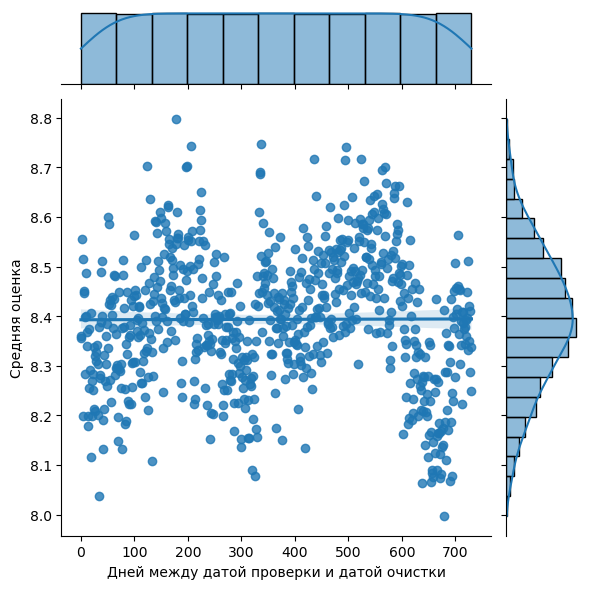

In [86]:
days_since_review = hotels[hotels['sample']].groupby(
    ['days_since_review'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=days_since_review, 
    x='days_since_review', y='reviewer_score', kind='reg')
plt.xlabel('Дней между датой проверки и датой очистки');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком days_since_review и целевым признаком reviewer_score: {}%'
    .format(
          round(hotels[['days_since_review','reviewer_score']].corr().iloc[0,1] * 100, 3)))

Визуально фиксируем корреляцию близкую к нулю

### Создание признака km_from_hotel_to_center (расстояние от отеля до центра города) на основании признаков lat и lng (координаты отеля), признаков Latitude и Longitude (кооднинаты центра города) из справичника Population (справочник популяций по городам), при помощи модуля distance библиотеки geopy

In [87]:
# Создаем словарь уникальных пар координат (lat, lng, Latitude, Longitude):km 
# на основе признаков lat, lng и Latitude, Longitude 
# путем вычисления дистанции между координатами отеля и
# координатами центра города при помощи метода distance.distance 
# библиотеки geopy
lst_couple_coordinates = list(hotels.merge(Population, left_on='hotel_city', 
    right_on = 'Name', how='left').groupby(['lat','lng',
    'Latitude','Longitude']).groups)
dict_distances = {}
for couple_coordinates in lst_couple_coordinates:
    dict_distances[couple_coordinates] = distance.distance((couple_coordinates[0],
    couple_coordinates[1]), (couple_coordinates[2], couple_coordinates[3])).km


In [88]:
# Создаем новый непрерывный признак km_from_hotel_to_center на основе
# словаря (lat, lng, Latitude, Longitude):km
def get_km_from_hotel_to_center(feature):
    return dict_distances[feature[0],feature[1],feature[2],feature[3]]
hotels['km_from_hotel_to_center'] = hotels.merge(Population, left_on='hotel_city', 
    right_on = 'Name', how='left')[['lat','lng',
    'Latitude','Longitude']].apply(get_km_from_hotel_to_center, axis=1)

Корреляция между признаком km_from_hotel_to_center и целевым признаком reviewer_score: -2.157%


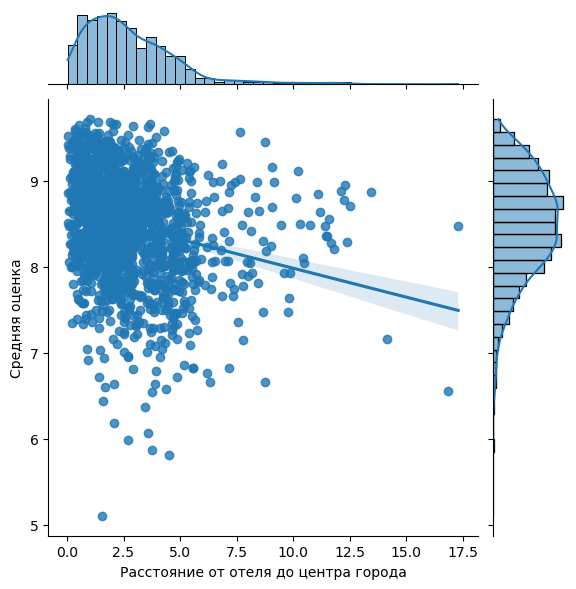

In [89]:
km_from_hotel_to_center = hotels[hotels['sample']].groupby(
    ['km_from_hotel_to_center'],
    as_index=False)['reviewer_score'].mean()
sns.jointplot(data=km_from_hotel_to_center, 
    x='km_from_hotel_to_center', y='reviewer_score', kind='reg')
plt.xlabel('Расстояние от отеля до центра города');
plt.ylabel('Средняя оценка');
print(
    'Корреляция между признаком km_from_hotel_to_center и целевым признаком reviewer_score: {}%'
    .format(
    round(hotels[['km_from_hotel_to_center','reviewer_score']].corr().iloc[0,1] * 100, 3)))

Зафиксирована слабая отрицательная корреляция между: признаками расстояние от отеля до центра города и целевого признака. Чем меньше расстояние тем чуть выше оценка.

### Формирование списка ненужных признаков 

In [90]:
# Объявляем список для удаления исходных ненужных признаков
features_for_del = features_for_del+ [s for s in hotels.columns 
                    if hotels[s].dtypes == 'object' or
                    s in ['review_date', 'lat', 'lng']]
features_for_del = list(set(features_for_del))
print('Список ненужных признаков для удаления:')
features_for_del

Список ненужных признаков для удаления:


['hotel_name',
 'hotel_country',
 'tags',
 'hotel_address',
 'negative_review',
 'positive_review',
 'lng',
 'review_date',
 'room_description',
 'lat']

##  <center>  Нормализация и стандартизация числовых признаков

### Объявление числовых признаков

In [91]:
# Если данный код выполняетя повторно, то перед 
# маштабированием удаляем из датасета hotels ранее 
# созданные отдельно маштабированные непрерывные признаки
try:
    if numerical_features_scaled: 
        hotels = hotels.drop(numerical_features_scaled, axis = 1)
except:
    pass
finally:
    numerical_features_scaled = []
# Создаем список числовых признаков (булевые признаки сюда не включаем),
# предназначенных для маштабирования
numerical_features_scaling = []
for feature in [s for s in hotels.columns 
                   if hotels[s].dtypes not in ['category', 'bool'] 
                and s not in features_for_del+['reviewer_score']]:
    if (hotels[feature].max() > 1) or hotels[feature].min() < -1:
        numerical_features_scaling.append(feature)
print('Список числовых признаков предназначенных для маштабирования:')
numerical_features_scaling

Список числовых признаков предназначенных для маштабирования:


['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'tourist_arrivals',
 'hotel_country_gdp_rank',
 'reviewer_country_gdp_rank',
 'hotel_city_population',
 'km_from_reviewer_nationality_to_hotel',
 'tags_weight',
 'km_from_hotel_to_center']

### Визуальное представление распределения числовых признаков, которые необходимо маштабировать 

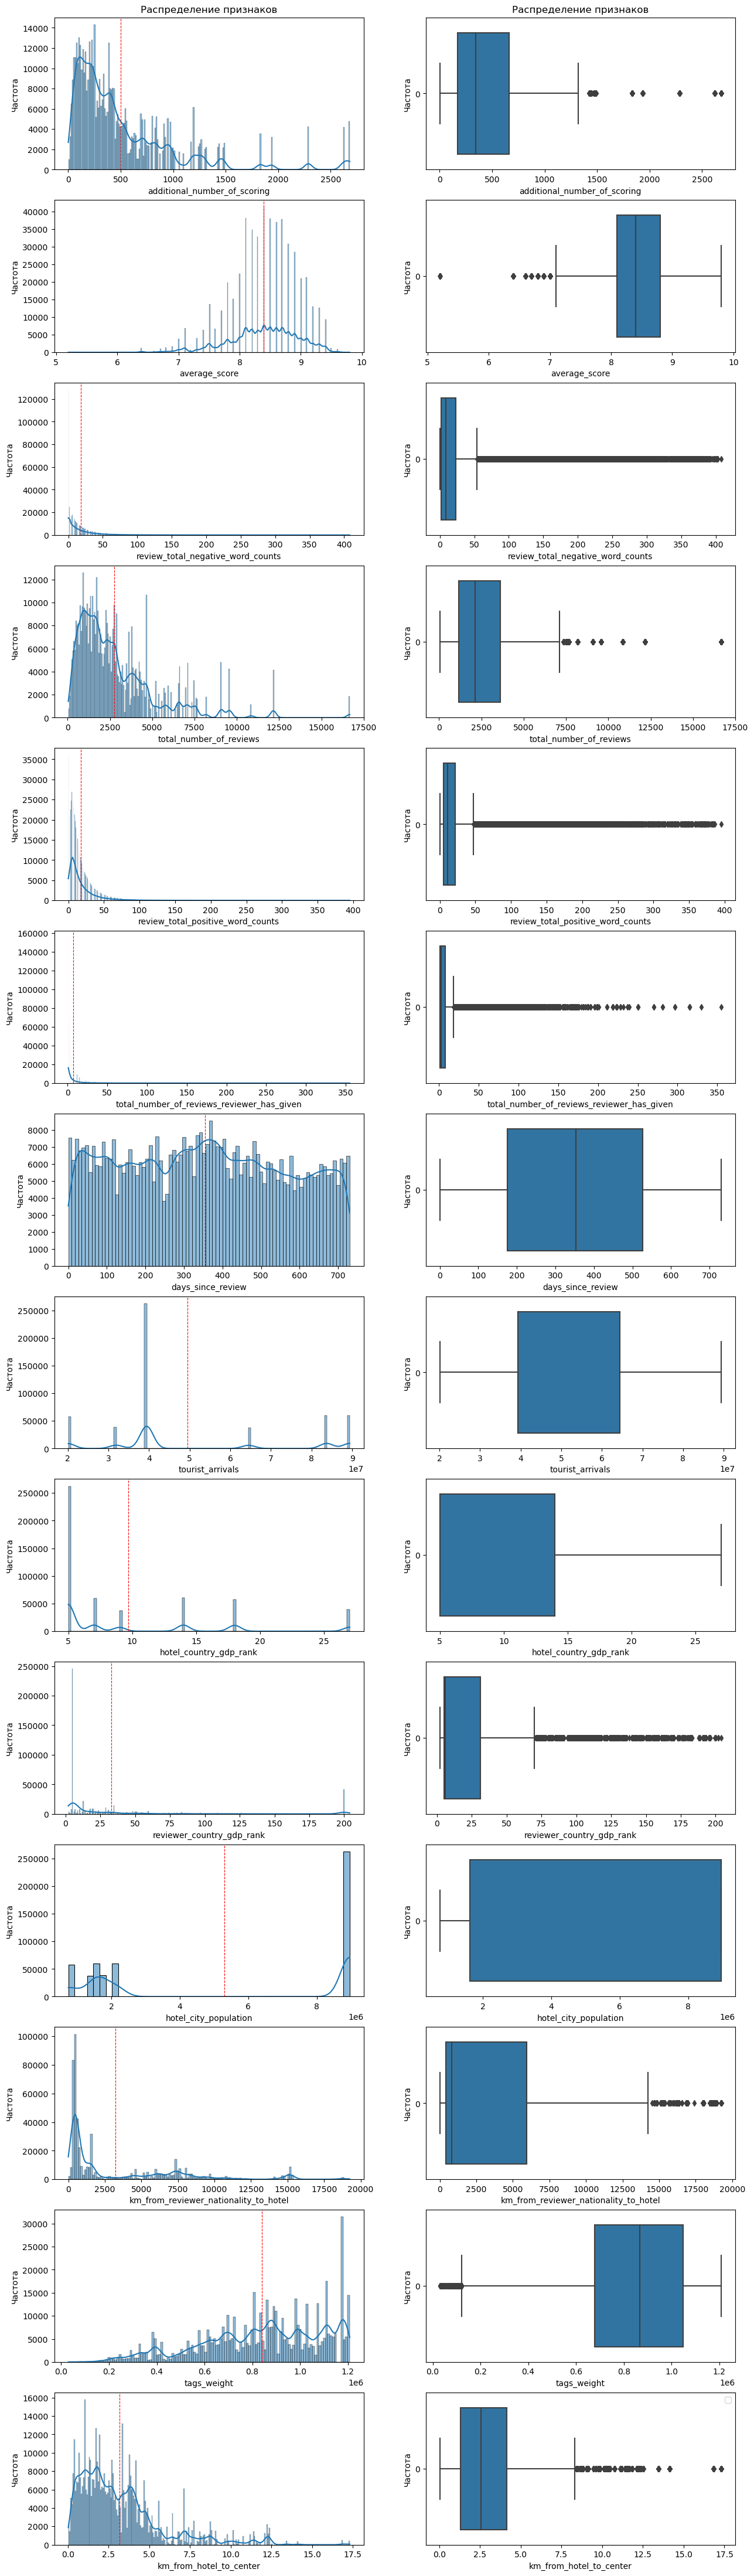

In [92]:
# Для определения метода маштабирования построим диаграммы распределения
fig, axes = plt.subplots(len(numerical_features_scaling), 2,
        figsize=(15, len(numerical_features_scaling)*4))
for index, feature in enumerate(numerical_features_scaling):
    sns.histplot(hotels[feature], kde=True, ax=axes[index][0])
    axes[index][0].set(xlabel=feature, ylabel='Частота')
    if index == 0:
        axes[index][0].set_title('Распределение признаков')
    axes[index][0].axvline(hotels[feature].mean(), color='red', 
                           linestyle='--', linewidth=0.8)
    sns.boxplot(hotels[feature], orient='h', ax=axes[index][1])
    axes[index][1].set(xlabel=feature, ylabel='Частота')
    if index == 0:
        axes[index][1].set_title('Распределение признаков')
    
plt.legend();

Визуально признаки, которые требуются маштабировать распределены не нормально, некоторые из них имеют выбросы. Создадим универсальный алгоритм проверяющий распределен ли признак норамально, и есть ли в признаке выбросы. Исходя и этого будет выбран соответсвующий метод маштабирования признака.

### Маштабирование числовых признаков

In [93]:
# Объявляем вспомогательную функцию по определению наличия выбросов в признаке
def there_are_outliers(data, feature) -> bool:
    '''
    Функция определяющая методом Тьюки наличие выбросов в признаке
    Args:
        data (DataFrame): датасет
        feature (str): наименование признака
    Returns:
        boolean: возвращает True если выбросы в признаке есть в наличии 
    '''
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return x.min() < lower_bound or x.max() > upper_bound

In [94]:
# При вызове метода stats.shapiro() выходит предупреждение:
# UserWarning: p-value may not be accurate for N > 5000
# Отключаем UserWarning
warnings.simplefilter("ignore", UserWarning)

In [95]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [96]:
# Приступаем к маштабированию признаков,
# исходные признаки не трогаем, создаем отдельные,
# т.к. код в данной ячейке может быть исполнен повторно
for feature in numerical_features_scaling:
    # С помощью теста Шапиро-Уилка проверим, нормально ли распределён признак 
    result = stats.shapiro(hotels[feature])
    if result[1] <= alpha:
        print('Признак {} распределен не нормально,'.format(feature))
        # С помощью метода Тьюки проверим, есть ли выбросы
        if there_are_outliers(hotels, feature):
            print('в признаке {} имеются выбросы, используем RobustScaler().'
                  .format(feature))
            r_scaler = preprocessing.RobustScaler()
            hotels[feature + '_scaled'] = r_scaler.fit_transform(
                hotels[feature].values.reshape(hotels.shape[0],1))
        else:
            print('в признаке {} нет выбросов, используем MinMaxScaler().'
                  .format(feature))
            mm_scaler = preprocessing.MinMaxScaler()
            hotels[feature + '_scaled'] = mm_scaler.fit_transform(
                hotels[feature].values.reshape(hotels.shape[0],1))
    else:
        print('Признак {} распределен нормально,'.format(feature))
        print('используем StandardScaler().')
        s_scaler = preprocessing.StandardScaler()
        hotels[feature + '_scaled'] = s_scaler.fit_transform(
            hotels[feature].values.reshape(hotels.shape[0],1))  
    numerical_features_scaled.append(feature + '_scaled')

Признак additional_number_of_scoring распределен не нормально,
в признаке additional_number_of_scoring имеются выбросы, используем RobustScaler().
Признак average_score распределен не нормально,
в признаке average_score имеются выбросы, используем RobustScaler().
Признак review_total_negative_word_counts распределен не нормально,
в признаке review_total_negative_word_counts имеются выбросы, используем RobustScaler().
Признак total_number_of_reviews распределен не нормально,
в признаке total_number_of_reviews имеются выбросы, используем RobustScaler().
Признак review_total_positive_word_counts распределен не нормально,
в признаке review_total_positive_word_counts имеются выбросы, используем RobustScaler().
Признак total_number_of_reviews_reviewer_has_given распределен не нормально,
в признаке total_number_of_reviews_reviewer_has_given имеются выбросы, используем RobustScaler().
Признак days_since_review распределен не нормально,
в признаке days_since_review нет выбросов, используем MinM

In [97]:
print('Маштабированные непрерывные признаки:')
hotels[numerical_features_scaled].describe()

Маштабированные непрерывные признаки:


,additional_number_of_scoring_scaled,average_score_scaled,review_total_negative_word_counts_scaled,total_number_of_reviews_scaled,review_total_positive_word_counts_scaled,total_number_of_reviews_reviewer_has_given_scaled,days_since_review_scaled,tourist_arrivals_scaled,hotel_country_gdp_rank_scaled,reviewer_country_gdp_rank_scaled,hotel_city_population_scaled,km_from_reviewer_nationality_to_hotel_scaled,tags_weight_scaled,km_from_hotel_to_center_scaled
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143,0.485537,0.423953,0.212446,1.026145,0.555075,0.434247,-0.071781,0.216176
std,1.019427,0.782926,1.413849,0.945132,1.282599,1.577175,0.286203,0.325489,0.303262,2.091246,0.454543,0.739928,0.678024,0.914123
min,-0.692464,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,0.000000,0.000000,0.000000,-0.153846,0.000000,-0.145186,-2.262268,-0.896712
25%,-0.350305,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,0.239726,0.278499,0.000000,-0.038462,0.107039,-0.070422,-0.514283,-0.439261
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483562,0.278499,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.649695,0.571429,0.666667,0.603181,0.647059,0.714286,0.721918,0.640693,0.409091,0.961538,1.000000,0.929578,0.485717,0.560739
max,4.767821,2.000000,19.000000,5.928222,22.588235,50.285714,1.000000,1.000000,1.000000,7.615385,1.000000,3.335918,0.917593,5.249220


##  <center>  Кодирование категориальных признаков

### Объявление категориальных признаков

In [98]:
# Создаем список категориальных признаков
categorical_features = [s for s in hotels.columns 
                   if hotels[s].dtypes == 'category' and s not in features_for_del]
print('Категориальные признаки:')
categorical_features

Категориальные признаки:


['reviewer_nationality',
 'hotel_city',
 'review_day_of_week',
 'review_week',
 'review_month',
 'review_quarter',
 'review_year',
 'hotel_name_address',
 'trip_type',
 'travelers',
 'number_of_nights']

### Кодируем категориальные признаки
Среди категориальных признаков одни номинальные, поэтому используем методы однократного и бинарного кодирования

In [99]:
# Кодируем номинальные признаки.
# Если данный код выполняетя повторно, то перед 
# кодированием удаляем из датасета hotels ранее 
# созданные закодированные булевые признаки
try:
    if lst_coded_features:
        hotels = hotels.drop(lst_coded_features, axis=1)
except:
    pass
finally:
    lst_coded_features = []   
for feature in categorical_features: 
    if hotels[feature].nunique() < 32:
        one_hot_encoder = ce.OneHotEncoder(cols=[feature], use_cat_names=True)        
        features_one_hot = one_hot_encoder.fit_transform(hotels[feature]).astype('bool')
        lst_coded_features.extend(features_one_hot)
        hotels = pd.concat([hotels, features_one_hot], axis=1)
        print('Признак {} кодируем однократным методом OneHotEncoder(),'.format(feature))
    else:
        bin_encoder = ce.BinaryEncoder(cols=[feature])
        features_bin = bin_encoder.fit_transform(hotels[feature]).astype('bool')
        lst_coded_features.extend(features_bin)
        hotels = pd.concat([hotels, features_bin], axis=1)
        print('Признак {} кодируем бинарным методом BinaryEncoder(),'.format(feature))

Признак reviewer_nationality кодируем однократным методом OneHotEncoder(),
Признак hotel_city кодируем однократным методом OneHotEncoder(),
Признак review_day_of_week кодируем однократным методом OneHotEncoder(),
Признак review_week кодируем бинарным методом BinaryEncoder(),
Признак review_month кодируем однократным методом OneHotEncoder(),
Признак review_quarter кодируем однократным методом OneHotEncoder(),
Признак review_year кодируем однократным методом OneHotEncoder(),
Признак hotel_name_address кодируем бинарным методом BinaryEncoder(),
Признак trip_type кодируем однократным методом OneHotEncoder(),
Признак travelers кодируем однократным методом OneHotEncoder(),
Признак number_of_nights кодируем однократным методом OneHotEncoder(),


##  <center>  Отбор признаков

### Визуализация важности числовых признаков

In [100]:
# Для определения статистической значимости признаков
# создаем отдельное представление, с заполненым 
# целевым признаком reviewer_score
samples = hotels[hotels['sample']]

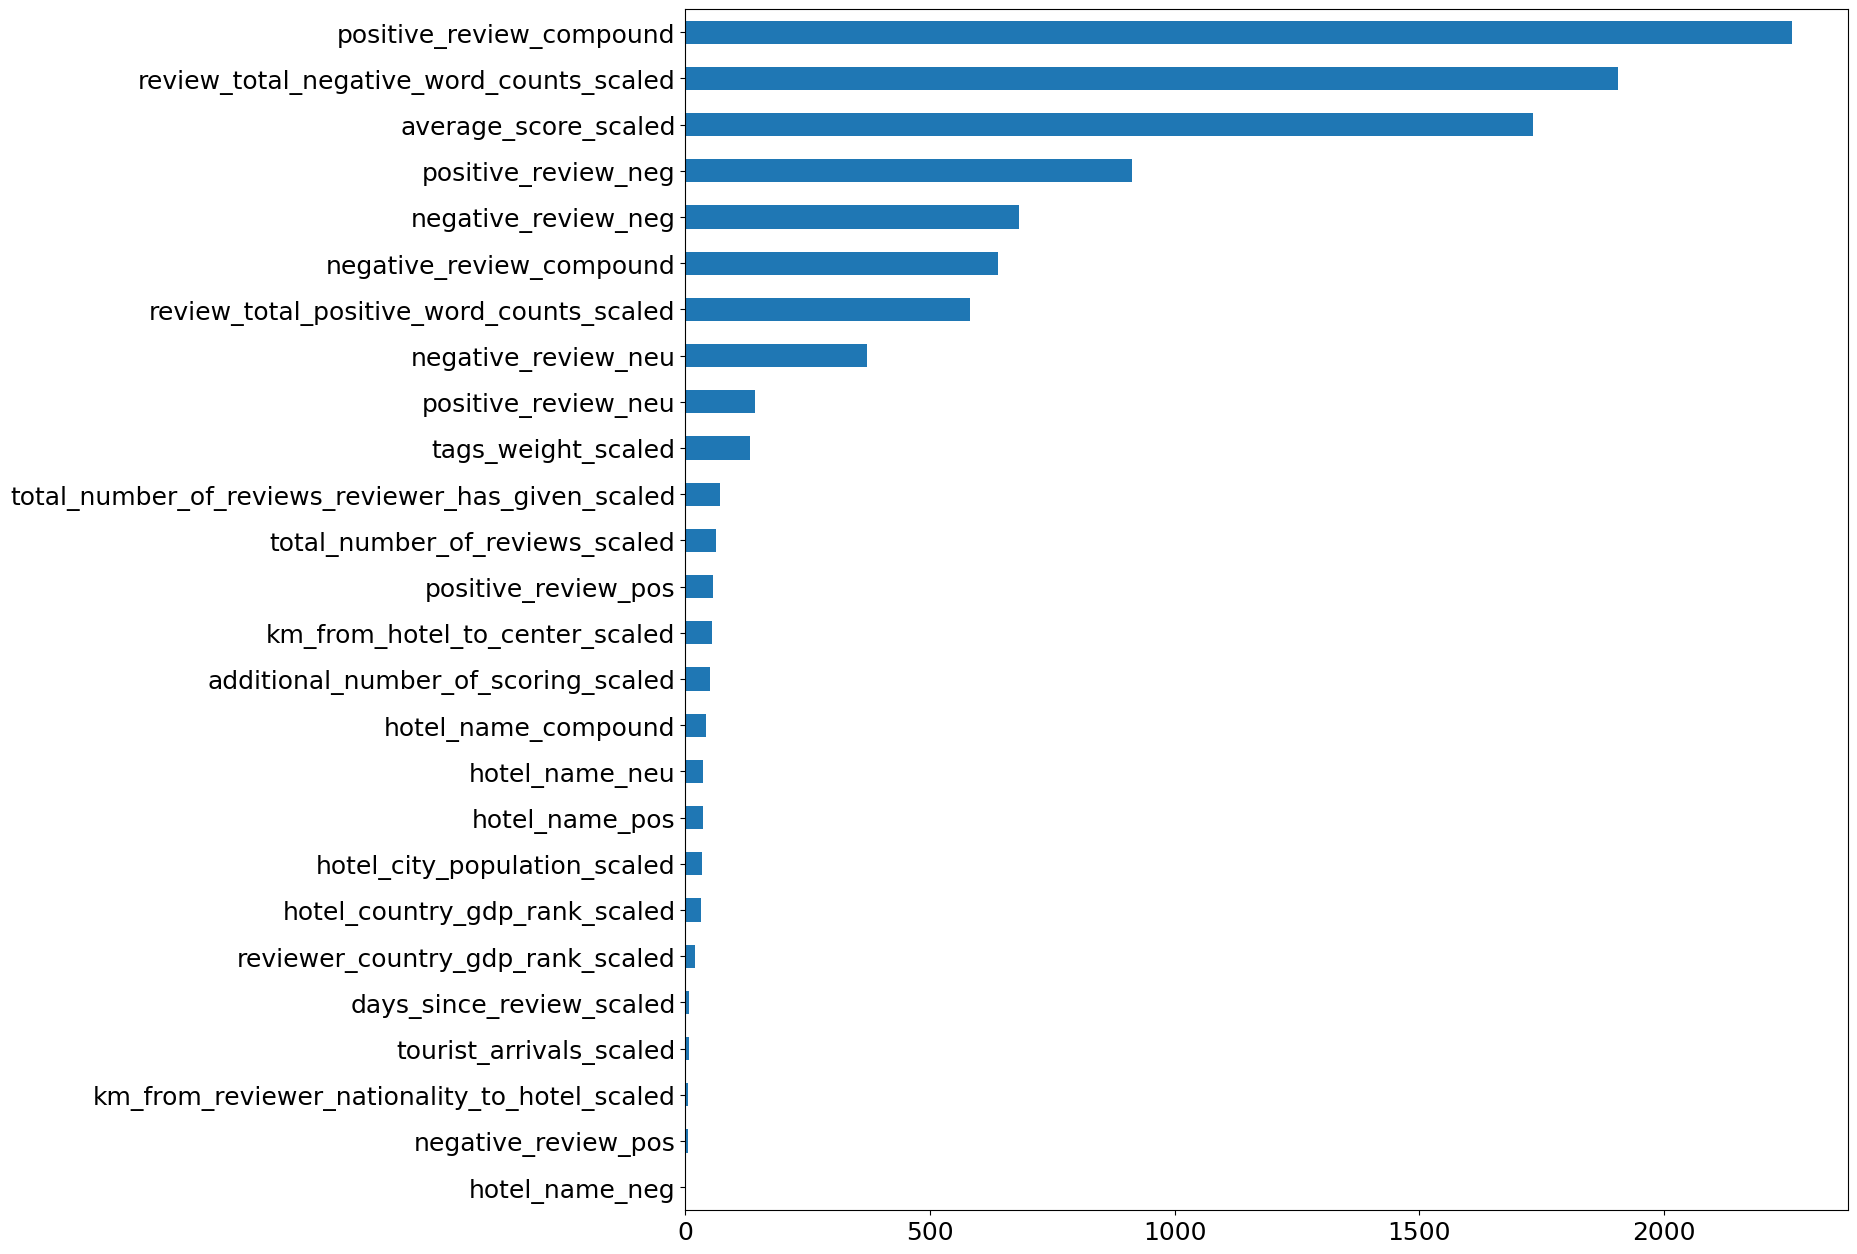

In [101]:
# Объявляем числовые признаки, которые будут
# учавствоввать в обучении 
numerical_features = [s for s in hotels.columns 
                    if hotels[s].dtypes == 'float64' 
                    and s not in features_for_del + 
                    numerical_features_scaling + ['reviewer_score']]
# Используем метод f_classif, в основе которого лежит анализ (ANOVA)
imp_num = pd.Series(f_classif(samples[numerical_features],
                            samples['reviewer_score'])[0],
                            index = numerical_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', 
             figsize = (15, len(numerical_features)*0.6), fontsize=18);

### Визуализация важности булевых признаков

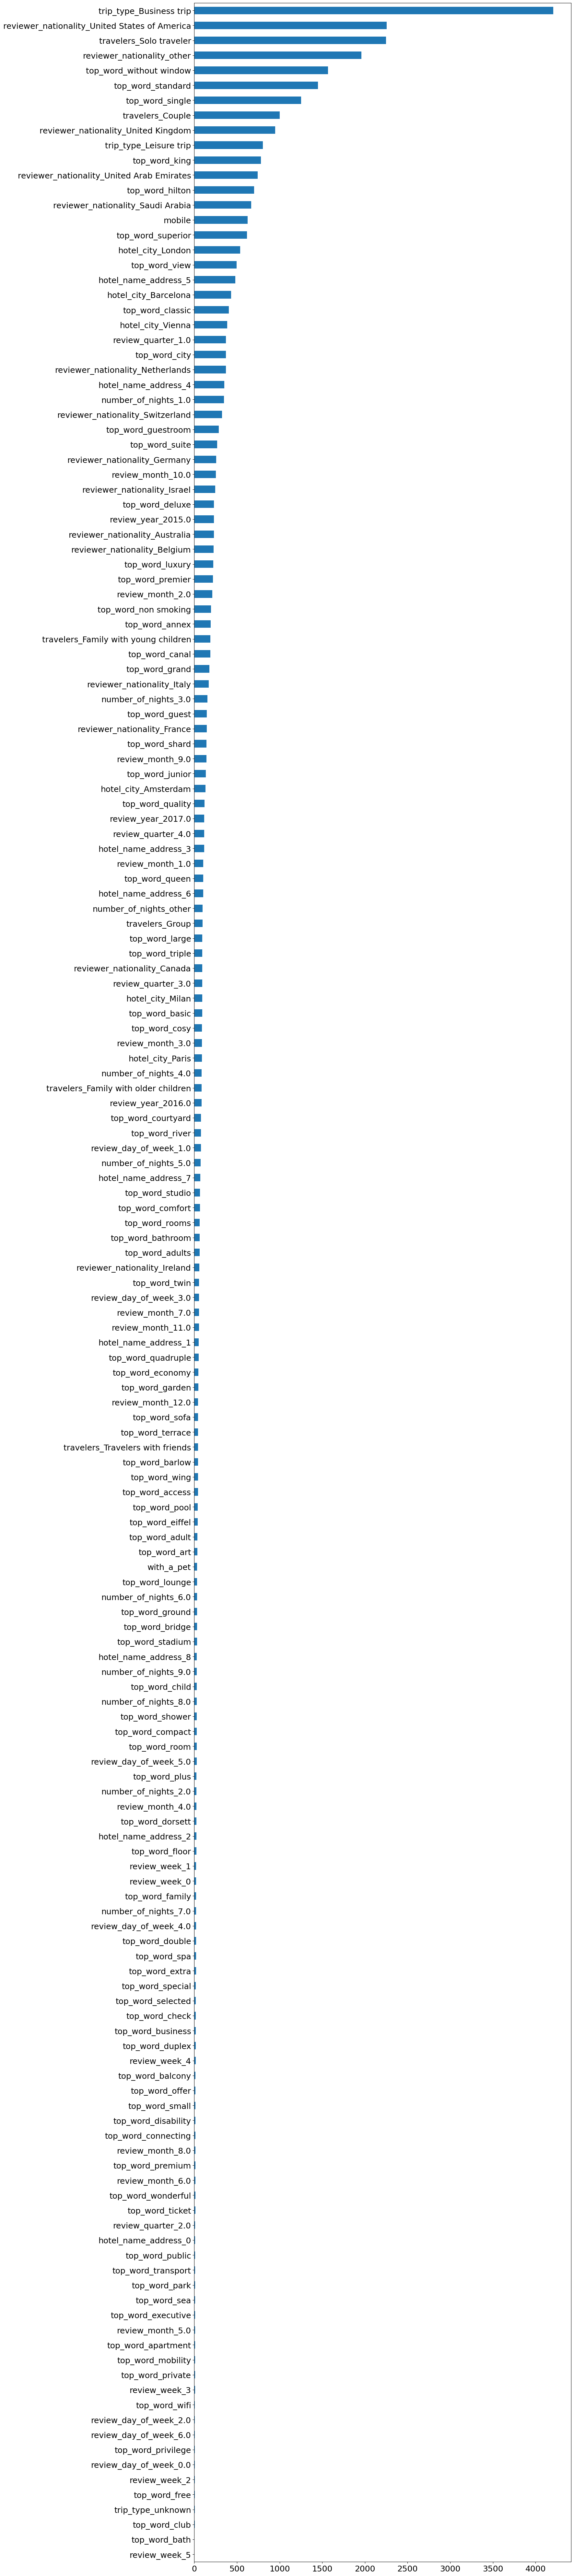

In [102]:
# Объявляем булевые признаки, которые будут
# учавствоввать в обучении 
boolean_features = [s for s in hotels.columns 
                   if (hotels[s].dtypes == 'bool') and s != 'sample']
# Используем непараметрический тест хи-квадрат для
# определения статистической значимости признаков
imp_cat = pd.Series(chi2(samples[boolean_features], 
                        samples['reviewer_score'].astype('int'))[0],
                        index=boolean_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize = (15,len(boolean_features)*0.6), 
             fontsize=18);

### Анализ мультиколлинеарности числовых признаков

In [103]:
# Отразим мультиколениарные числовые признаки 
hotels_numerical_corr = hotels[numerical_features].corr()
dict_numerical_corr = {}
for index in hotels_numerical_corr.index:
    for column in hotels_numerical_corr.columns:
        corr = hotels_numerical_corr.loc[index, column]
        if index != column and (corr <= -0.7 or corr >= 0.7):
            dict_numerical_corr[tuple(sorted((index, column)))] = corr
print('Числовые мультиколениарные признаки:')
dict_numerical_corr

Числовые мультиколениарные признаки:


{('hotel_name_neu', 'hotel_name_pos'): -0.9968144022779755,
 ('hotel_name_compound', 'hotel_name_neu'): -0.9565991680060535,
 ('hotel_name_compound', 'hotel_name_pos'): 0.9669014682896158,
 ('positive_review_neu', 'positive_review_pos'): -0.8821549463712358,
 ('additional_number_of_scoring_scaled',
  'total_number_of_reviews_scaled'): 0.824883778101206,
 ('hotel_city_population_scaled',
  'hotel_country_gdp_rank_scaled'): -0.7348286691055381}

In [104]:
# Строим множество числовых признаков, предназначенных для удаления
numerical_features_for_remove = set()
for couple_features in dict_numerical_corr:
    if imp_num[couple_features[0]] > imp_num[couple_features[1]]:
        numerical_features_for_remove.add(couple_features[1])
    else:
        numerical_features_for_remove.add(couple_features[0])
print('Наименее значимые числовые мультиколениарные признаки:')
numerical_features_for_remove

Наименее значимые числовые мультиколениарные признаки:


{'additional_number_of_scoring_scaled',
 'hotel_country_gdp_rank_scaled',
 'hotel_name_neu',
 'hotel_name_pos',
 'positive_review_pos'}

### Анализ мультиколлинеарности булевых признаков

In [105]:
# Отразим мультиколениарные булевые признаки 
hotels_boolean_corr = hotels[boolean_features].corr()
dict_boolean_corr = {}
for index in hotels_boolean_corr.index:
    for column in hotels_boolean_corr.columns:
        corr = hotels_boolean_corr.loc[index, column]
        if index != column and (corr <= -0.7 or corr >= 0.7):
            dict_boolean_corr[tuple(sorted((index, column)))] = corr
print('Булевые мультиколениарные признаки:')
dict_boolean_corr

Булевые мультиколениарные признаки:


{('top_word_adult', 'top_word_adults'): 0.9588767563096938,
 ('top_word_apartment', 'top_word_art'): 0.7927999020796964,
 ('top_word_offer', 'top_word_special'): 0.9254132598327913,
 ('top_word_barlow', 'top_word_wing'): 1.0,
 ('top_word_floor', 'top_word_ground'): 0.7505650801282454,
 ('top_word_check', 'top_word_selected'): 0.9952679783690411,
 ('top_word_public', 'top_word_transport'): 1.0,
 ('top_word_public', 'top_word_ticket'): 0.9987128568672902,
 ('top_word_ticket', 'top_word_transport'): 0.9987128568672902,
 ('trip_type_Business trip', 'trip_type_Leisure trip'): -0.9998922567153742}

In [106]:
# Строим множество булевых признаков, предназначенных для удаления
boolean_features_for_remove = set()
for couple_features in dict_boolean_corr:
    if imp_cat[couple_features[0]] > imp_cat[couple_features[1]]:
        boolean_features_for_remove.add(couple_features[1])
    else:
        boolean_features_for_remove.add(couple_features[0])
print('Наименее значимые булевые мультиколениарные признаки:')
boolean_features_for_remove

Наименее значимые булевые мультиколениарные признаки:


{'top_word_adult',
 'top_word_apartment',
 'top_word_barlow',
 'top_word_check',
 'top_word_floor',
 'top_word_offer',
 'top_word_public',
 'top_word_transport',
 'trip_type_Leisure trip'}

### Добавляем к множеству признаков для удаления наименее значимые

In [107]:
# Добавляем к множествам признаков для удаления, 50%
# самых статистически незначимых.
numerical_features_for_remove = numerical_features_for_remove.union(
    imp_num.index[0:int(len(imp_num)*0.5)])
boolean_features_for_remove = boolean_features_for_remove.union(
    imp_cat.index[0:int(len(imp_cat)*0.5)])

In [108]:
print('Итоговый список числовых признаков предназначенных для удаления:')
numerical_features_for_remove

Итоговый список числовых признаков предназначенных для удаления:


{'additional_number_of_scoring_scaled',
 'days_since_review_scaled',
 'hotel_city_population_scaled',
 'hotel_country_gdp_rank_scaled',
 'hotel_name_compound',
 'hotel_name_neg',
 'hotel_name_neu',
 'hotel_name_pos',
 'km_from_hotel_to_center_scaled',
 'km_from_reviewer_nationality_to_hotel_scaled',
 'negative_review_pos',
 'positive_review_pos',
 'reviewer_country_gdp_rank_scaled',
 'tourist_arrivals_scaled'}

In [109]:
print('Итоговый список булевых признаков предназначенных для удаления:')
boolean_features_for_remove

Итоговый список булевых признаков предназначенных для удаления:


{'hotel_name_address_0',
 'hotel_name_address_1',
 'hotel_name_address_2',
 'hotel_name_address_8',
 'number_of_nights_2.0',
 'number_of_nights_6.0',
 'number_of_nights_7.0',
 'number_of_nights_8.0',
 'number_of_nights_9.0',
 'review_day_of_week_0.0',
 'review_day_of_week_2.0',
 'review_day_of_week_3.0',
 'review_day_of_week_4.0',
 'review_day_of_week_5.0',
 'review_day_of_week_6.0',
 'review_month_11.0',
 'review_month_12.0',
 'review_month_4.0',
 'review_month_5.0',
 'review_month_6.0',
 'review_month_7.0',
 'review_month_8.0',
 'review_quarter_2.0',
 'review_week_0',
 'review_week_1',
 'review_week_2',
 'review_week_3',
 'review_week_4',
 'review_week_5',
 'top_word_access',
 'top_word_adult',
 'top_word_apartment',
 'top_word_art',
 'top_word_balcony',
 'top_word_barlow',
 'top_word_bath',
 'top_word_bridge',
 'top_word_business',
 'top_word_check',
 'top_word_child',
 'top_word_club',
 'top_word_compact',
 'top_word_connecting',
 'top_word_disability',
 'top_word_dorsett',
 'top_w

### Удаление исходных ненужных признаков, а также мультиколениарных и наименее значимых

In [110]:
# Создаем отдельные датасет без исходных признаков,
# оставляем которые пригодны для обучения, т.е. 
# те которые не требовалось менять и 
# отдельно созданные в результате кодирования и 
# маштабирования
hotels_finish = \
    hotels.drop(
        # 'object's, review_date, lat, lng
        features_for_del + 
        # категориальные
        categorical_features + 
        # непрерывные
        numerical_features_scaling + 
        list(boolean_features_for_remove) + # муль-ные и незанчимые
        list(numerical_features_for_remove), axis=1)

In [111]:
hotels_finish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 99 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   sample                                             515738 non-null  bool   
 1   reviewer_score                                     515738 non-null  float64
 2   negative_review_neg                                515738 non-null  float64
 3   negative_review_neu                                515738 non-null  float64
 4   negative_review_compound                           515738 non-null  float64
 5   positive_review_neg                                515738 non-null  float64
 6   positive_review_neu                                515738 non-null  float64
 7   positive_review_compound                           515738 non-null  float64
 8   mobile                                             515738 non-null  bool  

##  <center>  Обучение модели

In [112]:
# Теперь выделим тестовую часть
train_data = hotels_finish.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_finish.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [113]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [114]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 98), (386803, 98), (386803, 97), (309442, 97), (77361, 97))

In [115]:
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [116]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [117]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8634912949246604


In [118]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12265801988997181


<Axes: >

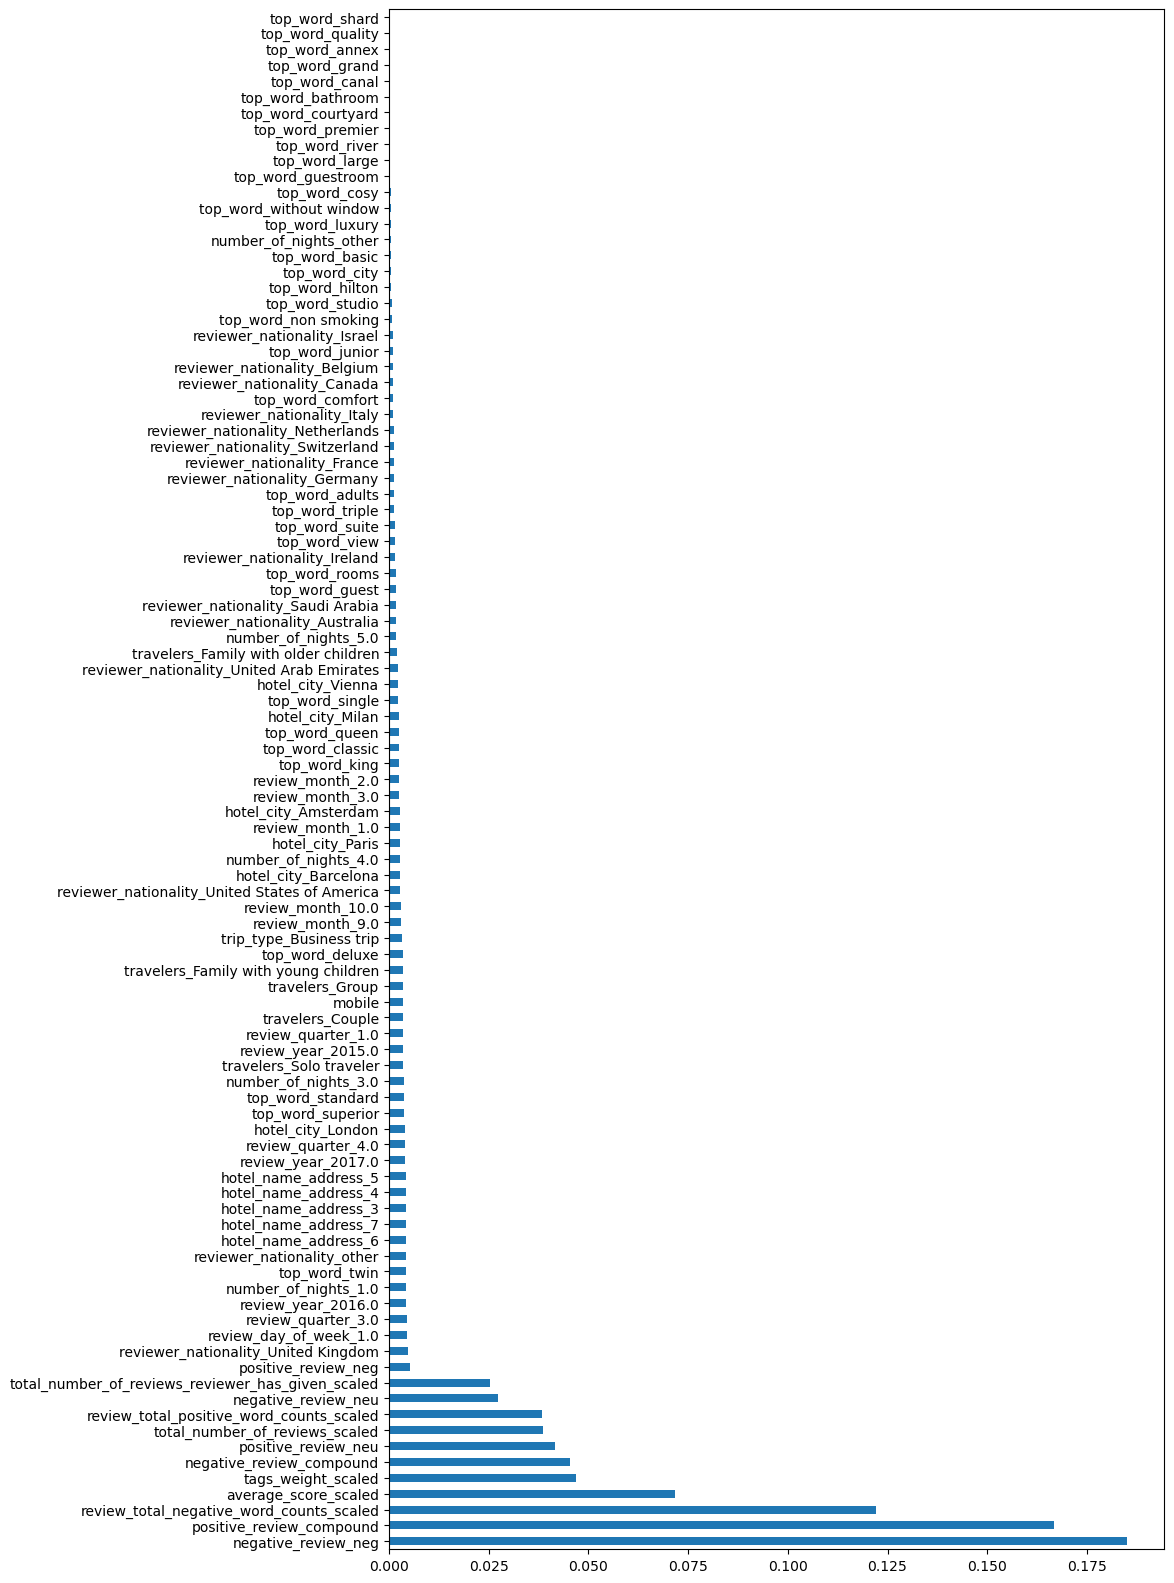

In [119]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,20)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(100).plot(kind='barh')

In [120]:
test_data.sample(10)

,reviewer_score,negative_review_neg,negative_review_neu,negative_review_compound,positive_review_neg,positive_review_neu,positive_review_compound,mobile,top_word_twin,top_word_standard,...,travelers_Couple,travelers_Group,travelers_Solo traveler,travelers_Family with young children,travelers_Family with older children,number_of_nights_1.0,number_of_nights_3.0,number_of_nights_4.0,number_of_nights_5.0,number_of_nights_other
36263,0.0,0.156,0.844,-0.2584,0.000,0.250,0.7184,False,False,False,...,False,False,True,False,False,False,False,False,False,False
100534,0.0,0.346,0.654,-0.5719,0.184,0.816,-0.4019,True,False,False,...,False,False,False,True,False,True,False,False,False,False
30265,0.0,0.000,1.000,0.0000,0.000,0.547,0.7003,True,False,False,...,False,False,False,True,False,False,False,False,False,False
10952,0.0,0.000,1.000,0.0000,0.000,0.473,0.9505,True,True,True,...,True,False,False,False,False,False,True,False,False,False
66520,0.0,0.341,0.659,-0.4767,0.000,0.508,0.4404,False,False,False,...,False,False,False,True,False,False,False,False,False,False
47942,0.0,0.262,0.738,-0.5499,0.024,0.797,0.8909,False,True,False,...,False,True,False,False,False,True,False,False,False,False
77464,0.0,0.000,1.000,0.0000,0.000,0.707,0.6997,False,False,False,...,False,False,True,False,False,False,True,False,False,False
7442,0.0,0.229,0.771,-0.8835,0.000,0.564,0.4754,True,False,False,...,True,False,False,False,False,True,False,False,False,False
72433,0.0,0.459,0.541,-0.5267,0.000,0.412,0.6908,True,False,True,...,False,False,True,False,False,False,False,True,False,False
113083,0.0,0.000,1.000,0.0000,0.000,0.351,0.5719,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [121]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [122]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [123]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [124]:
predict_submission

array([8.414, 7.101, 8.544, ..., 8.406, 9.553, 7.287])

In [125]:
list(sample_submission)

['reviewer_score', 'id']

In [126]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.414,488440
1,7.101,274649
2,8.544,374688
3,9.759,404352
4,9.572,451596
5,8.901,302161
6,7.230,317079
7,7.624,13963
8,8.254,159785
9,7.786,195089
